In [1]:
#notebook to reproduce figs 2 e-g 

In [ ]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from vast import surface_tools
import pandas as pd
import scipy.stats as stats
import subprocess
import sklearn.decomposition # PCA
import sklearn.manifold
import scripts.nb_loaders as nbl
from cmath import rect, phase
from per_vertex_bb import get_tree_and_cortical_coords
from math import radians, degrees
from per_vertex_bb import rank_matrix,rank_vector
import matplotlib_surface_plotting as msp

import seaborn as sns
import scipy.stats as st

def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def subsample_surface(triangles,cortex, level=1):
    import vast.surface_tools as surf_t

    
    neighbours=surf_t.get_neighbours_from_tris(triangles)
    indexing = np.arange(len(neighbours))
    for l in np.arange(level):
        nn=np.empty(len(neighbours),dtype=object)
        
        for k,n in enumerate(neighbours):
            nn_i=np.zeros(len(neighbours)).astype(bool)
            
            for v in n:
                nn_i[np.array(neighbours[v])]=1
                
            nn[k]=indexing[nn_i]
        neighbours=nn
    vertices=[]
    remaining = cortex.copy()
    while np.sum(remaining)>0:
        vertex_added = indexing[remaining][0]
        vertices.append(vertex_added)
        remaining[np.array(neighbours[vertex_added])]=0
        remaining[vertex_added]=0
    return np.sort(vertices)
    

In [4]:
#load in flat vectors
base_dir = '/data1/allen_surfaces/'
n_genes=20781
flat_vectors = np.load(os.path.join(base_dir,'all_subs_flat_vector_gradients.npz'))['arr_0']

In [5]:
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0
spins = np.load('spin_dir/spins_1000.npy')
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.inflated.surf.gii'))


In [4]:
inflated_vectors = np.load('/data1/allen_surfaces/hcp_surfs_2/all_subs_infl_vector_gradients.npz')['arr_0']

In [5]:
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.very_inflated.surf.gii'))

subset=subsample_surface(surf.darrays[1].data,cortex,level=3)
pca=sklearn.decomposition.PCA(n_components=3)
pc_vectors_inflated = np.zeros((len(cortex),2))
inflated_pc_vectors=np.zeros((len(subset),3))
for k,v in enumerate(subset):
    vertex_vecs = inflated_vectors[:,:,v]
    pca.fit(vertex_vecs)
    inflated_pc_vectors[k] = pca.components_[0]

In [6]:
#calculate principal direction of gene gradients
vertices=np.where(cortex)[0]
pca=sklearn.decomposition.PCA(n_components=2)
pc_vectors = np.zeros((len(cortex),2))
gene_pc_ratio = np.zeros(len(cortex))

for k,v in enumerate(vertices):
    vertex_vecs = flat_vectors[:,:2,v]
    pca.fit(vertex_vecs)
    pc_vectors[v] = pca.components_[0]
    gene_pc_ratio[v] = pca.explained_variance_ratio_[0] #/pca.explained_variance_ratio_[1]
    

/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 2796.,     0.,     0.,     0.,     0.,  3516.,  9025., 10063.,
         5839.,  1248.]),
 array([0.        , 0.09922032, 0.19844063, 0.29766095, 0.39688126,
        0.49610158, 0.5953219 , 0.69454221, 0.79376253, 0.89298285,
        0.99220316]),
 <BarContainer object of 10 artists>)

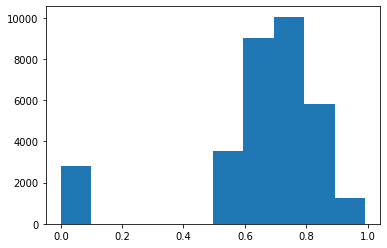

In [7]:
plt.hist(gene_pc_ratio[:v])

In [8]:
np.save('gradients/gene_pc_ratio.npy',gene_pc_ratio)
np.save('pc_vectors.npy',pc_vectors)

In [9]:
pc_vectors = np.load('pc_vectors.npy')

In [10]:
# fig = plt.figure(figsize=(10,10))
# # from nilearn import plotting, datasets
# # plotting.view_surf(os.path.join(base_dir,'hcp_surfs', subject,'MNINonLinear','fsaverage_LR32k',
# #                                 '{}.L.inflated.32k_fs_LR.surf.gii'.format(subject)),      
# #                            cmap='viridis', symmetric_cmap=False )
# ax = fig.gca()
# ax.scatter(flat['coords'][:,0], flat['coords'][:,1],c=gene_pc_ratio,vmax=0.9,s=7)
# ax.axis('equal')
# ax.axis('off')

In [11]:
grad=np.load(os.path.join(base_dir,'all_subs_gradients.npy'))


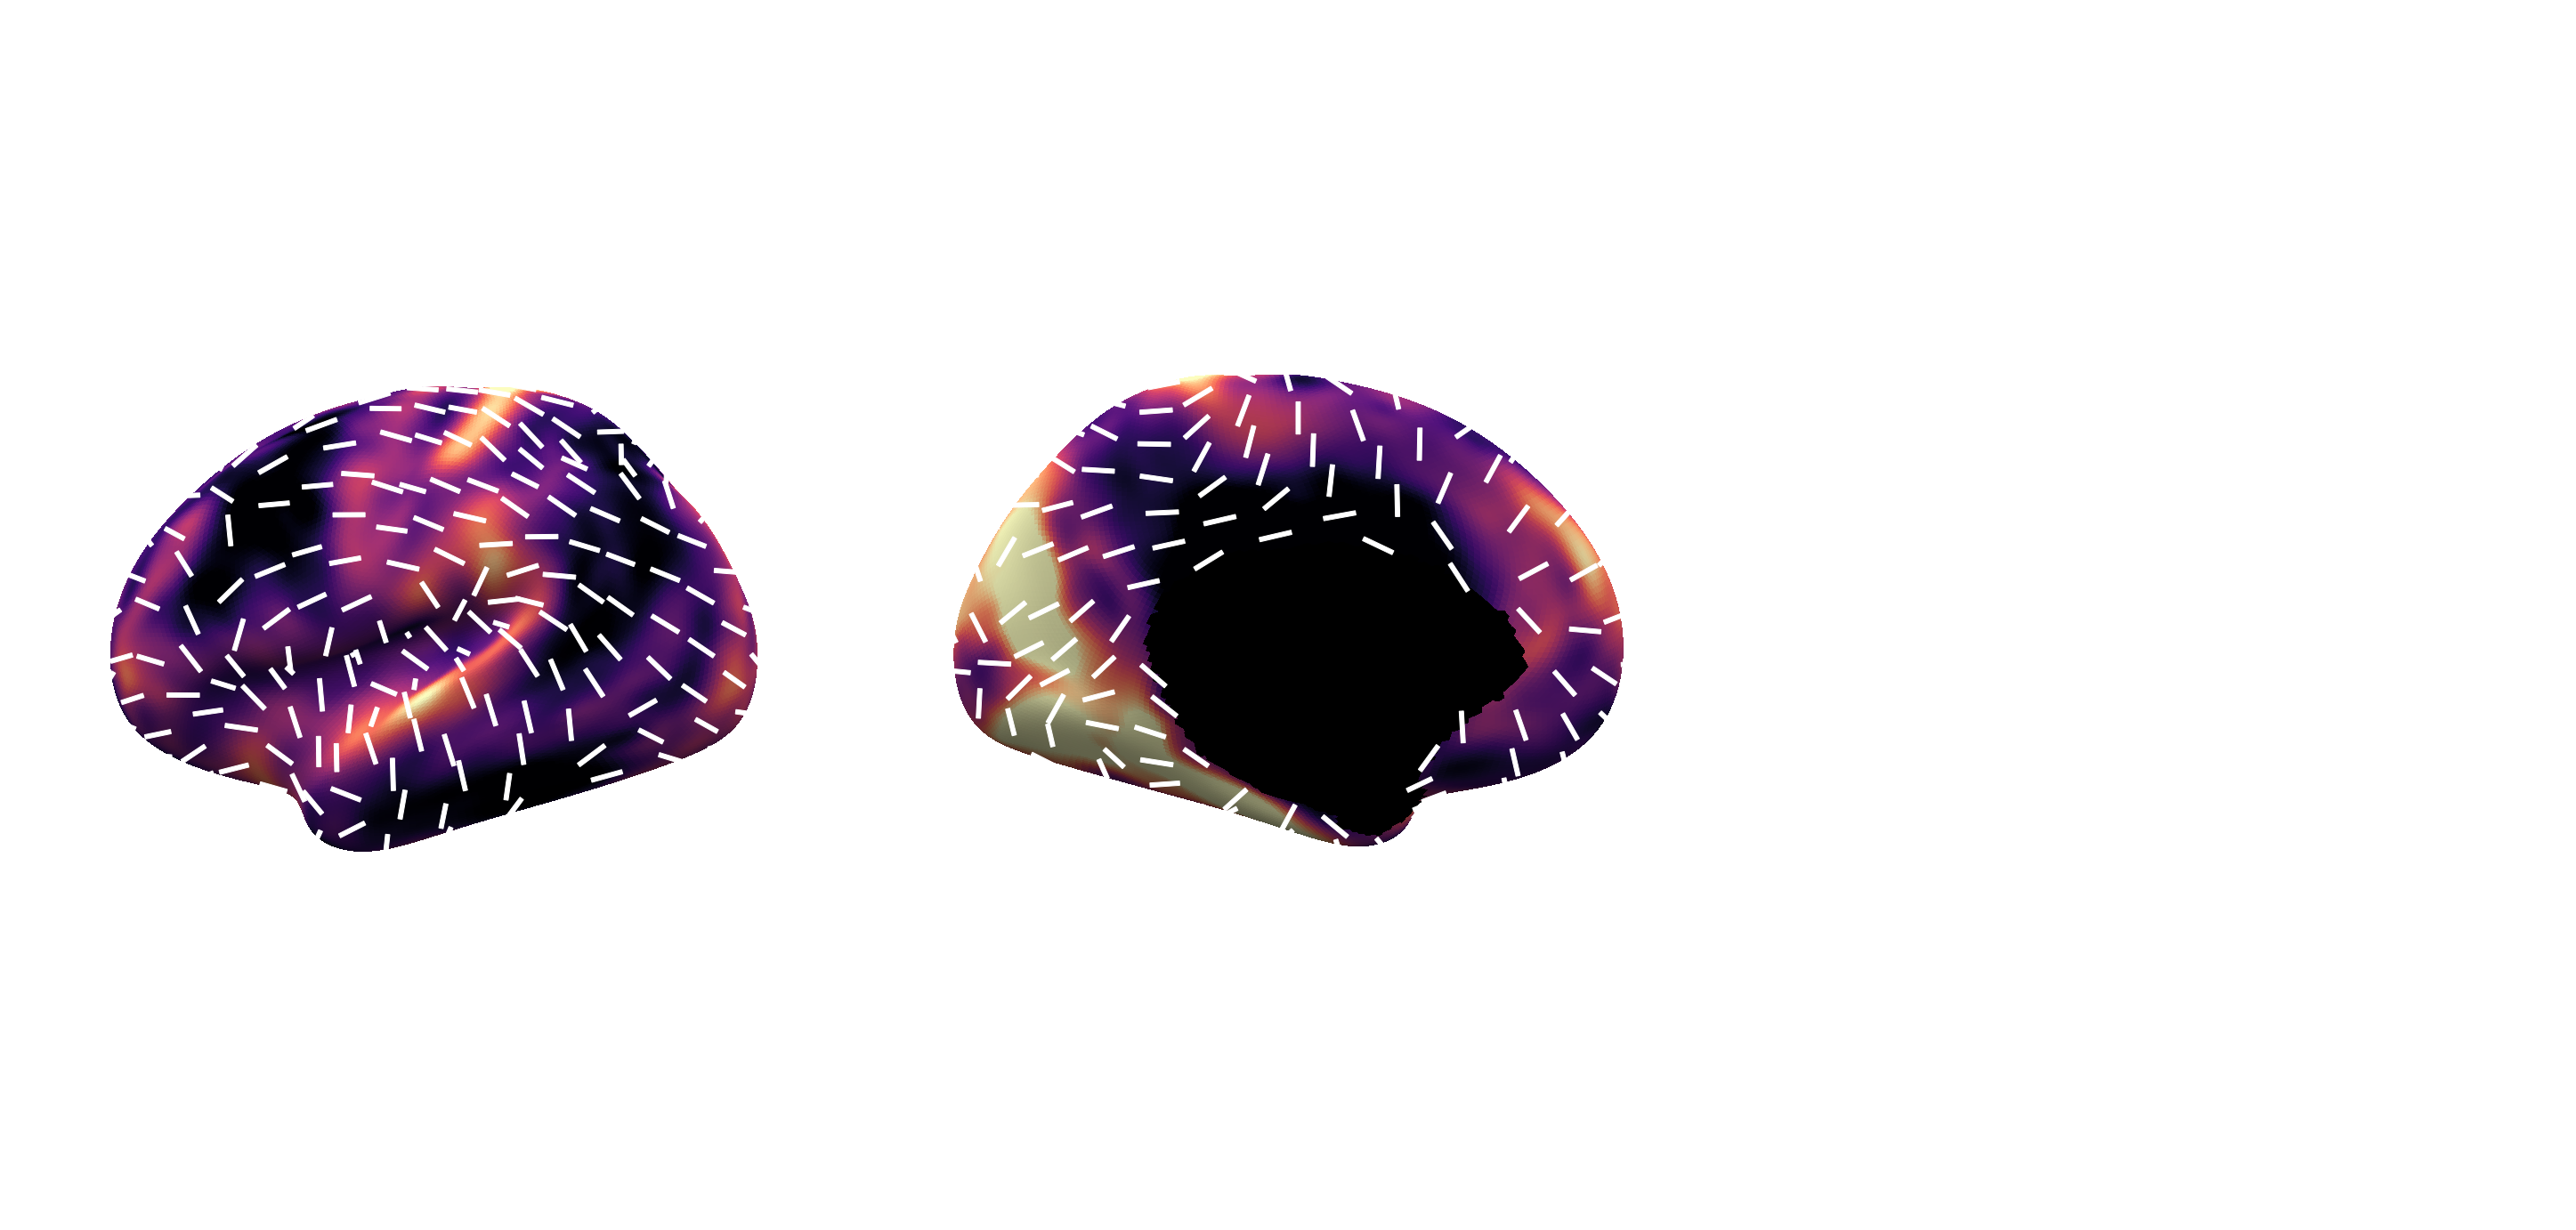

In [12]:
grad_mag=np.mean(grad,axis=0)
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.very_inflated.surf.gii'))

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,grad_mag,cmap='magma',
              rotate=[90,270],vmin = np.percentile(grad_mag,5),base_size=20,
              arrows=inflated_pc_vectors,arrow_subset=subset,arrow_head=0.0,arrow_width=0.01,
              arrow_size=0.05,arrow_colours=np.tile(np.array([1,1,1]),(len(subset),1)),mask_colour=np.array([0,0,0,1]),
                  vmax=np.percentile(grad_mag,95),mask=~cortex,pvals=np.ones_like(cortex),
             label=False,colorbar=False,filename='figures/pc_gradients.png')



findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


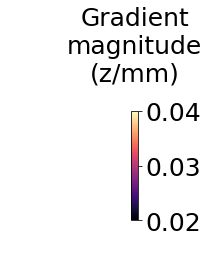

In [13]:
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 40}
import matplotlib
matplotlib.rc('font', **font)

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,grad_mag,cmap='magma',
              rotate=[],vmin = np.percentile(grad_mag,5),base_size=5,
              arrows=inflated_pc_vectors,arrow_subset=subset,arrow_head=0.0,arrow_width=0.01,
              arrow_size=0.05,arrow_colours=np.tile(np.array([1,1,1]),(len(subset),1)),
                  vmax=np.percentile(grad_mag,95),mask=~cortex,pvals=np.ones_like(cortex),
              cmap_label="Gradient\nmagnitude\n(z/mm)",colorbar=True,filename='figures/pc_gradients_cbar.pdf')


/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:9: RuntimeWarning: invalid value encountered in true_divide
  arr[:,0] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:10: RuntimeWarning: invalid value encountered in true_divide
  arr[:,1] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:11: RuntimeWarning: invalid value encountered in true_divide
  arr[:,2] /= lens


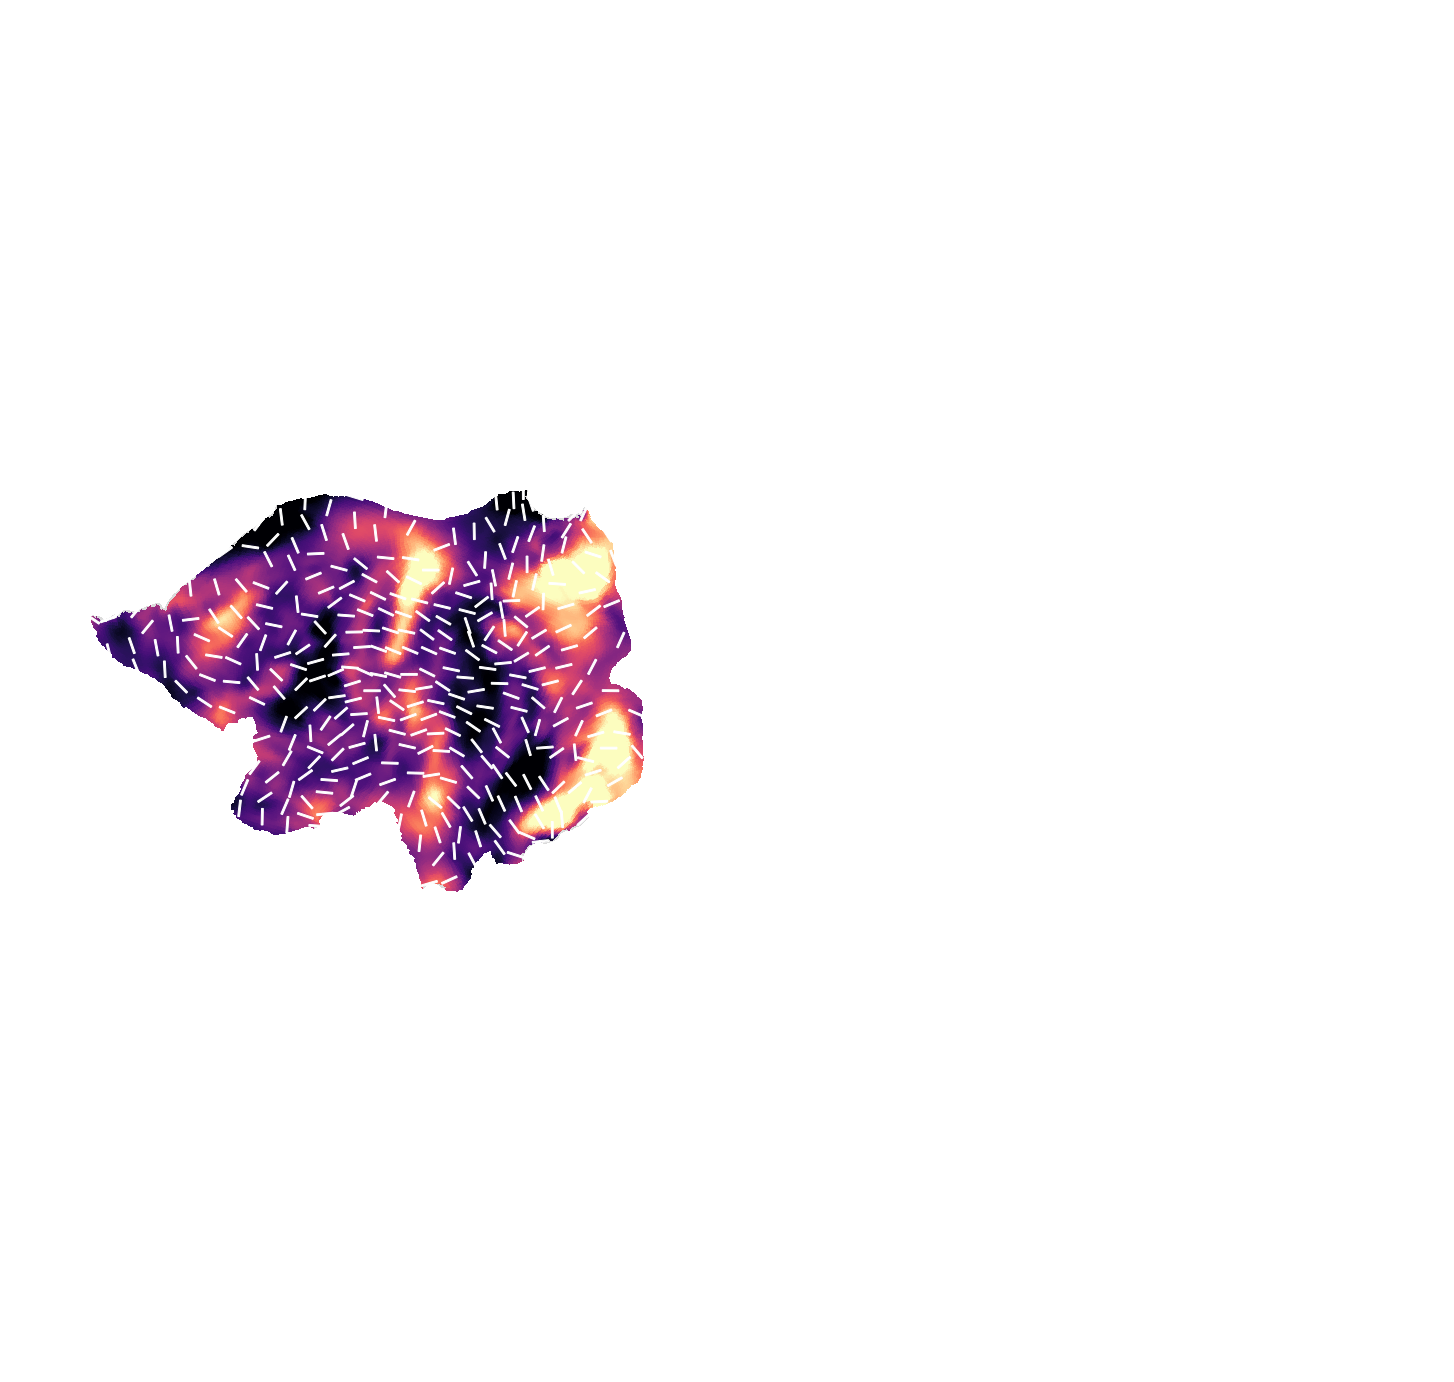

In [14]:
flat=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                                'fs_LR.32k.L.flat.surf.gii'))
pc_vectors_3d=np.zeros((len(pc_vectors),3))
pc_vectors_3d[:,:2]=pc_vectors
msp.plot_surf(flat.darrays[0].data,flat.darrays[1].data,grad_mag,cmap='magma',flat_map=True,
              rotate=[90,270],vmin = np.percentile(grad_mag,5),base_size=20,
              arrows=pc_vectors_3d,arrow_subset=subset,arrow_head=0.00,arrow_width=0.005,
              arrow_size=0.03,arrow_colours=np.tile(np.array([1,1,1]),(len(subset),1)),
                  vmax=np.percentile(grad_mag,95),mask=~cortex,pvals=np.ones_like(cortex),
             cmap_label=False,colorbar=False,filename='figures/pc_gradients_flat.png')

In [15]:
grad_mag=np.loadtxt('gradients/mean_z.txt')


In [6]:
#calculate PC direction for each vertex (or subset if slow) and gene ranks
parcellationf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                      'Glasser_2016.32k.L.label.gii'))
         
parcellation=parcellationf.agg_data()
neighbours=surface_tools.get_neighbours(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                                'fs_LR.32k.L.very_inflated.surf.gii'))
borders=[]
for roi in np.unique(parcellation):
    region=parcellation==roi
    flat_list = [item for sublist in list(neighbours[region]) for item in sublist]
    borders.extend(np.setdiff1d(np.array(flat_list),np.where(region)[0]))

In [17]:
sulc_vectors=np.load('/data1/allen_surfaces/hcp_surfs_2/template/folding_vectors.npy')


In [18]:
def calculate_peak_angles(angles):
    import statsmodels.api as sm

    """calculate peak angle among the windows using kde function"""
    
    kernel=sm.nonparametric.KDEUnivariate(angles)
    kernel.fit(bw=0.03)
    preds=np.zeros(360)
    for k,angle in enumerate(np.linspace(-np.pi,np.pi,360)):
        preds[k]=kernel.evaluate(angle)
    peak_angles=np.linspace(-np.pi,np.pi,360)[np.argmax(preds,axis=0)]
    return peak_angles

def angle_to_vectors(angles):
    return np.vstack([np.sin(angles),np.cos(angles)])

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector.T / np.linalg.norm(vector,axis=1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1).T
    v2_u = unit_vector(v2).T
    dot_product=np.einsum('ij,ij->i', v1_u,v2_u)
    return np.arccos(np.clip(dot_product, -1.0, 1.0))

def mean_vector(pc_vectors):
    "get vector describing mean orientation of group of angles"
    angles=np.arctan(pc_vectors[:,0]/pc_vectors[:,1])
    peak=calculate_peak_angles(angles)
    peak_vector=angle_to_vectors(peak.reshape(-1,1))
    return peak_vector.ravel()

In [19]:
n_perm=100
roi_vectors=np.zeros((len(np.unique(parcellation))-1,2))
mean_grad_vector_roi=np.zeros((len(np.unique(parcellation))-1,2))
mean_sulc_vector_roi=np.zeros((len(np.unique(parcellation))-1,2))

mean_mag = np.zeros(len(np.unique(parcellation))-1)
spun_mean_grad = np.zeros((n_perm,len(np.unique(parcellation))-1,2))
spun_mean_sulc = np.zeros((n_perm,len(np.unique(parcellation))-1,2))

pc_vectors_c = pc_vectors[cortex]
sulc_vectors_c = sulc_vectors[cortex]
pca=sklearn.decomposition.PCA(n_components=2)
roi_ratio = np.zeros((len(np.unique(parcellation))-1))
region_gene_ratio = np.zeros((len(np.unique(parcellation))-1))
spun_region_gene_ratio = np.zeros((len(np.unique(parcellation))-1,n_perm))
com_inds=np.zeros(len(np.unique(parcellation))-1).astype(int)

for k,roi in enumerate(np.unique(parcellation)[1:]):
    print(k)
    region=parcellation==roi
    vector_roi = flat.darrays[0].data[region,:2]
    vector_roi = vector_roi - np.mean(vector_roi,axis=0)
    pca.fit(vector_roi)
    com = np.mean(vector_roi,axis=0)
    com_inds[k]=np.where(region)[0][np.argmin(np.linalg.norm(vector_roi-com,axis=1))]
    

    roi_vectors[k] = pca.components_[1]
    roi_ratio[k] = pca.explained_variance_ratio_[0]-pca.explained_variance_ratio_[1]
    
    mean_grad_vector_roi[k] = mean_vector(pc_vectors[region]) #np.mean(pc_vectors[region],axis=0)
    mean_sulc_vector_roi[k] = mean_vector(sulc_vectors[region]) #np.mean(sulc_vectors[region],axis=0)
    region_gene_ratio[k] = np.median(gene_pc_ratio[region], axis=0)
    
    region_c = region[cortex]
    spun_region= region_c[spins]
    for p in np.arange(n_perm):
        spc=pc_vectors_c[spins[p]][region_c]
        mas=~(spc==0).all(axis=1)
        spun_mean_grad[p,k,:] = mean_vector(spc[mas])
        spc=sulc_vectors_c[spins[p]][region_c]
        mas=~(spc==0).all(axis=1)
        #np.nanmedian(pc_vectors_c[spins[p]][region_c],axis=0)
        spun_mean_sulc[p,k,:] = mean_vector(spc[mas]) #np.nanmedian(sulc_vectors_c[spins[p]][region_c],axis=0)
        spun_region_gene_ratio[k,p]= np.median(gene_pc_ratio[cortex][spins[p]][region_c], axis=0)
    mean_mag[k] = np.mean(grad_mag[region])
    

0


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


1
2


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


3


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


4


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


5


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


6


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


7


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


8


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


9


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


10


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


11
12
13


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


14


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


15


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


16


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


17


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


18


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


19


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


20


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


21


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


22
23


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


24


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


25


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


26
27


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


28
29


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


30


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


31


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


32


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


33


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


34


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


35


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


36


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


37


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


38


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


39
40
41


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


42


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


43


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


44
45
46


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


47
48
49
50


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


51


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


52


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


53


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


54


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


55
56
57


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


58


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


59


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


60
61


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


62


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


63
64


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


65


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


66


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


67
68


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


69
70
71
72


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


73
74


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


75
76
77


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


78


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


79


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


80


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


81


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


82


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


83


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


84


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


85


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


86
87


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


88
89


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


90


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


91


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


92


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


93


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


94


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


95


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


96


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


97


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


98


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


99


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


100


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


101


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


102


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


KeyboardInterrupt: 

In [ ]:
#colour map

color_dict={}
for k,roi in enumerate(np.unique(parcellation)):
    color_dict[roi]= np.clip(np.array(parcellationf.labeltable.labels[k].rgba)+0.2,0,1)

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,
              parcellation[:len(cortex)],parcel=parcellation[:len(cortex)],filled_parcels=True,parcel_cmap=color_dict,
             colorbar=False,base_size=20,
             filename='figures/glasser.png')

In [ ]:
roi_vectors_3d= np.zeros((len(roi_vectors),3))
roi_vectors_3d[:,:2]=roi_vectors[:]
msp.plot_surf(flat.darrays[0].data,flat.darrays[1].data,parcellation,cmap='magma',flat_map=True,
              rotate=[90,270],vmin = np.percentile(grad_mag,5),base_size=20,
              parcel=parcellation[:len(cortex)],filled_parcels=True,parcel_cmap=color_dict,
              arrows=roi_vectors_3d,arrow_subset=com_inds,arrow_head=0.00,arrow_width=0.002,
              arrow_size=0.04,arrow_colours=np.tile(np.array([0,0,0]),(len(subset),1)),
                  vmax=np.percentile(grad_mag,95),mask=~cortex,pvals=np.ones_like(cortex),
             label=False,colorbar=False,filename='figures/glasser_flat.png')

In [ ]:
corr_spun=np.zeros(1000)
for p in np.arange(1000):
    mask=~np.isnan(spun_region_gene_ratio[:,p])
    corr_spun[p] = np.corrcoef(roi_ratio[mask],spun_region_gene_ratio[mask,p])[0,1]
    


In [ ]:
mask=~np.isnan(region_gene_ratio)
corr_base=np.corrcoef(roi_ratio[mask],region_gene_ratio[mask])[0,1]
p=np.mean(corr_base<corr_spun)

In [ ]:
st.spearmanr(roi_ratio[mask],region_gene_ratio[mask])

In [ ]:
sns.regplot(roi_ratio[mask],region_gene_ratio[mask])
plt.text(0.2,0.7, f'r={np.round(corr_base,2)}\np<0.01')
plt.xlabel('ROI spatial eccentricity')
plt.ylabel('Genetic eccentricity')
#TODO SPIN test on parcellation

In [ ]:
filled_ratios=np.zeros(len(cortex))
for k,roi in enumerate(np.unique(parcellation)[1:]):
    region=parcellation==roi
    filled_ratios[region] =roi_ratio[k]

In [ ]:
# plt.scatter(roi_ratio.argsort().argsort(),mean_mag.argsort().argsort())
# np.corrcoef(roi_ratio.argsort().argsort(),mean_mag.argsort().argsort())

In [20]:
import matplotlib_surface_plotting as msp
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.very_inflated.surf.gii'))

#msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,filled_ratios.argsort().argsort(),rotate=[270,90])
# plt.scatter(flat['coords'][:,0],flat['coords'][:,1],c=min_distances.argsort().argsort(),s=0.2)

In [21]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

(array([79., 11.,  6.,  9., 16., 10., 10., 10.,  9., 20.]),
 array([0.        , 0.09977605, 0.19955211, 0.29932816, 0.39910421,
        0.49888027, 0.59865632, 0.69843237, 0.79820843, 0.89798448,
        0.99776053]),
 <BarContainer object of 10 artists>)

findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


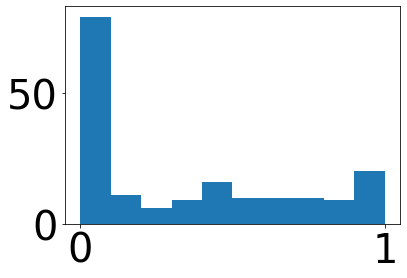

In [22]:
plt.hist(roi_ratio)

In [23]:
#consider masking out regions that are not eccentric
not_excentric=roi_ratio<0.6


In [24]:
n_perm=100
angles_between=nbl.minimum_angles(nbl.angle_between(mean_grad_vector_roi,roi_vectors))
angles_between_sg=nbl.minimum_angles(nbl.angle_between(mean_sulc_vector_roi,roi_vectors))

ks_stat = st.kstest(angles_between/(np.pi/2),'uniform')[0]
skew=st.skew(angles_between)
skew_sg=st.skew(angles_between_sg)


spun_stats = np.zeros(n_perm)
spun_stats_sg = np.zeros(n_perm)

spun_angle_dist = np.zeros((angles_between.shape[0],n_perm))
for p in np.arange(n_perm):
    spun_angles= nbl.minimum_angles(nbl.angle_between(spun_mean_grad[p],roi_vectors))
    spun_stats[p] = st.skew(spun_angles)
    spun_angle_dist[:,p]=spun_angles
    spun_angles= nbl.minimum_angles(nbl.angle_between(spun_mean_sulc[p],roi_vectors))
    spun_stats_sg[p] = st.skew(spun_angles)

/data1/bigbrain/phate_testing/scripts/nb_loaders.py:43: RuntimeWarning: invalid value encountered in true_divide
  return vector.T / np.linalg.norm(vector,axis=1)
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1956: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [ ]:
import matplotlib
fig, ax = plt.subplots(1,1,figsize=(5,5))
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)
skew= st.skew(angles_between_sg/(np.pi/2))
sns.distplot(np.rad2deg(angles_between_sg),kde=True,#bins=9,
             kde_kws={'clip': (0.0, 90.0),'bw':0.2,'cut':0},
             hist=False,
             ax=ax
            )
ax.set_ylabel('n vertices')
ax.set_xlabel('fMRI ROI\norientation vs folds (°)')
ax.set_xticks(np.linspace(0,90,2));
ax.set_yticks([]);

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(45,0.02,  'Skew = {}'.format(np.round(skew_sg,2))+
          
                                        '\np$_{spin}$<0.01',
          fontsize=23,
        verticalalignment='top', bbox=props)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('figures/glasser_sulc_skew.pdf')

In [ ]:
import matplotlib
fig, ax = plt.subplots(1,1,figsize=(5,5))
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)
skew= st.skew(angles_between_sg/(np.pi/2))
sns.distplot(np.rad2deg(angles_between_sg),kde=False,bins=9,
             #kde_kws={'clip': (0.0, 90.0),'bw':0.2,'cut':0},
             hist=True,)
ax.set_ylabel('n vertices')
ax.set_xlabel('fMRI ROI\norientation vs folds (°)')
ax.set_xticks(np.linspace(0,90,2));
ax.set_yticks([]);

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(45,50,  'Skew = {}'.format(np.round(skew_sg,2))+
          
                                        '\np$_{spin}$<0.01',
          fontsize=23,
        verticalalignment='top', bbox=props)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('figures/glasser_sulc_skew.pdf')

In [ ]:
        ` `

In [ ]:
multi_skew = np.zeros(21)

spun_skews=    np.zeros((21,1000))
for k,t in enumerate(np.linspace(0,0.9,21)):
    excentric=roi_ratio>t
    angles_between=nbl.minimum_angles(nbl.angle_between(mean_grad_vector_roi[excentric],
                                                        roi_vectors[excentric]))
    multi_skew[k]=st.skew(angles_between)
    for p in np.arange(1000):
        spun_angles_= nbl.minimum_angles(nbl.angle_between(spun_mean_grad[p][excentric],
                                                           roi_vectors[excentric]))
        spun_skews[k,p] = st.kstest(spun_angles_/(np.pi/2),'uniform')[0]

In [ ]:
fig,axes=plt.subplots(2,figsize=(4,10))
sns.distplot(roi_ratio,15,kde=True,ax=axes[0])
axes[0].set_xticks(np.arange(6)/5)
axes[0].set_xlim([0,1])
axes[0].set_ylabel('Frequency')

axes[1].plot(np.linspace(0,0.9,21),multi_skew,label='Measured skew')

axes[1].plot(np.linspace(0,0.9,21),spun_skews,c='grey',alpha=0.1)
axes[1].plot([0],[0],c='grey',alpha=0.8,label='Spun skews')

axes[1].legend()

axes[1].set_xlabel('Eccentricity threshold')
axes[1].set_xticks(np.arange(6)/5)
axes[1].set_xlim([0,0.9])
axes[1].set_ylabel('Skew')


In [ ]:
print(np.rad2deg(st.circmean(nbl.angle_between(mean_grad_vector_roi,roi_vectors)*2)/2))
print(np.rad2deg(st.circstd(nbl.angle_between(mean_grad_vector_roi,roi_vectors)*2)/2))
np.mean(ks_stat<spun_stats)

In [ ]:
masked_angles_between=angles_between.copy()
masked_angles_between[not_excentric]=90

In [ ]:
## import seaborn as sns
#angles_between=nbl.angle_between(mean_grad_vector_roi,roi_vectors)
sns.distplot(np.rad2deg(angles_between),10,kde=False)
#plt.plot([90,90],[0,0.01])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

plt.xlim([0,90])
plt.xlabel('Angle between ROI short axis\nand principal gene gradient')
plt.text(65,25,f'skew = {np.round(skew,2)}\nks stat={np.round(ks_stat,2)}\np_spin<0.01',bbox=props)

In [ ]:
# plt.hist(spun_stats)
# plt.plot([ks_stat,ks_stat],[0,250])
# np.mean(ks_stat<spun_stats)
# plt.xlabel('ks stat')

In [25]:
from scripts.mesh_operations import subsample_surface

In [26]:
subsample = subsample_surface(surf.darrays[1].data,cortex,level=3)

In [27]:
combined_arrows = np.zeros((len(com_inds)+len(com_inds),3))
combined_arrows[:,:2]=np.vstack([mean_grad_vector_roi,roi_vectors])
combined_arrows=combined_arrows/np.linalg.norm(combined_arrows,axis=1).reshape(-1,1)
combined_indices = np.hstack([com_inds,com_inds])
combined_colours = np.hstack([['k']*len(com_inds),['red']*len(com_inds),])

/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
angles_full = np.zeros(len(parcellation))
for region in np.arange(len(np.unique(parcellation))-1):
    angles_full[parcellation==region+1] = np.rad2deg(angles_between[region])

In [29]:
# flat=surface_tools.io_mesh.load_mesh_geometry(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
#                                     'fs_LR.32k.L.flat.surf.gii'))
# msp.plot_surf(flat['coords'],flat['faces'],angles_full,
#                   base_size=20,vmin=np.min(angles_full),vmax=90,
#                   cmap='prism',
#                  flat_map=True,label=True,
                 
#                   colorbar=False,cmap_label='Angle',
#               filename='tmp.png'
#                  )

In [30]:
import scripts.paths as p

/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 24286 results
  r = func(a, **kwargs)


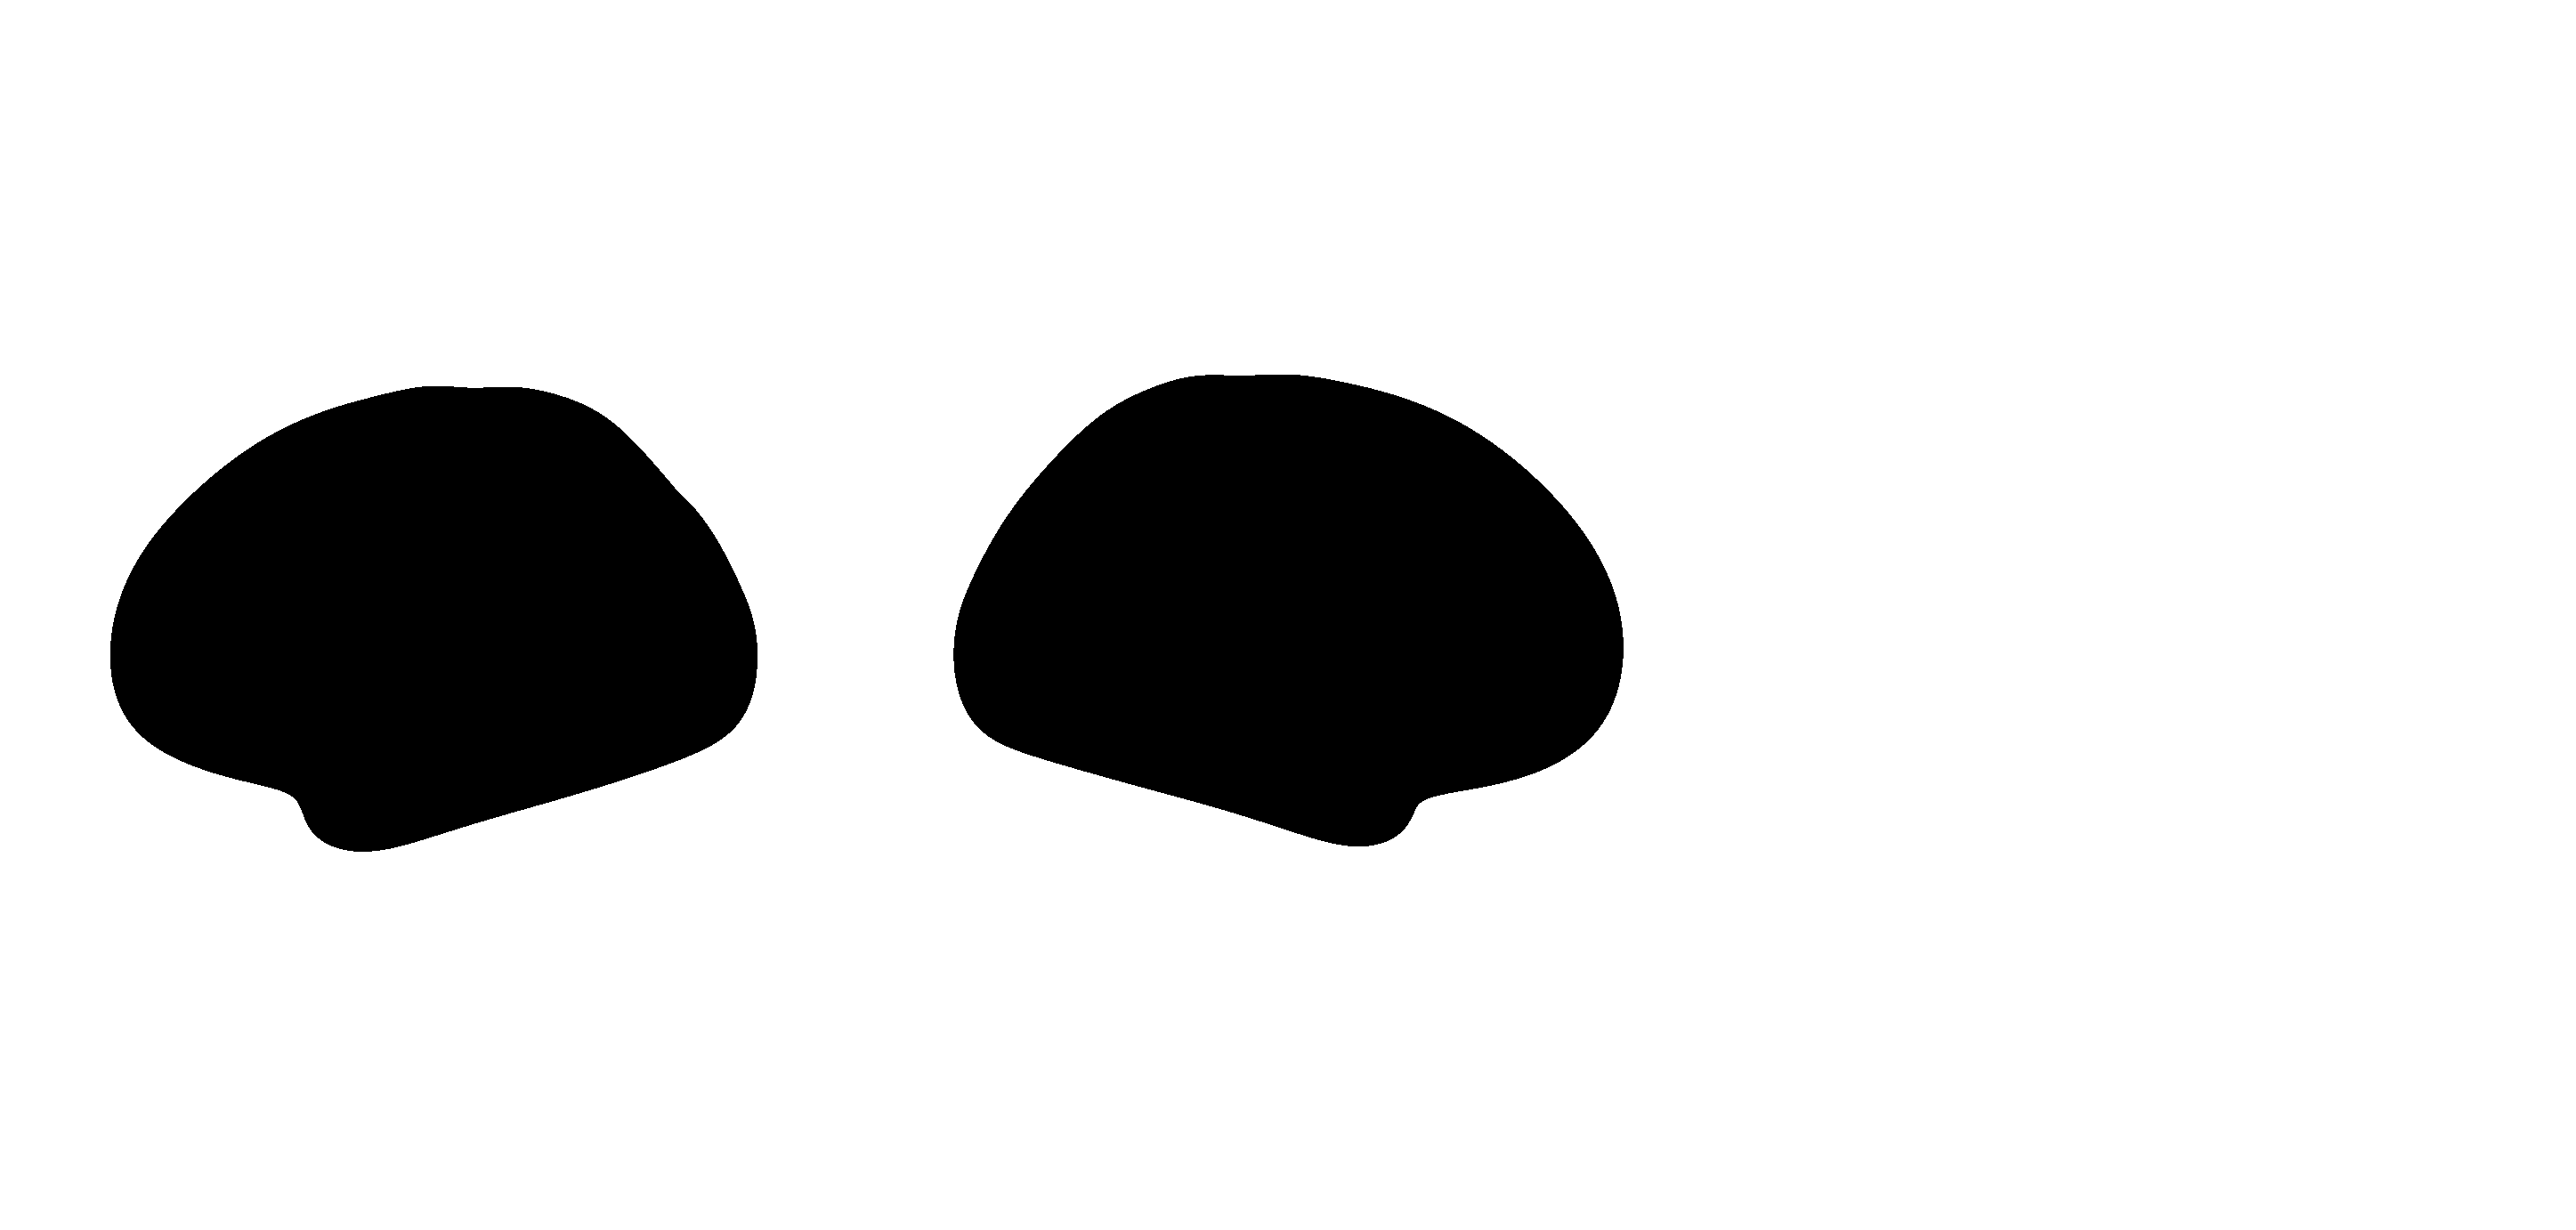

In [31]:
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,angles_full,
                  base_size=20,vmin=np.min(angles_full),vmax=90,
                  cmap=p.cmap_hex,
                 label=True,
                 mask=~cortex,mask_colour=np.array([0,0,0,1]),
              colorbar=False,
                 # colorbar=True,cmap_label='Angle',
              filename='figures/glasser_pc_dev.png'
                 )

In [ ]:
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,angles_full,rotate=[],
                  base_size=20,vmin=np.min(angles_full),vmax=90,
                  cmap=p.cmap_hex,
                 label=True,
                 mask=~cortex,
                  colorbar=True,cmap_label='Angle',
              filename='cbar.pdf'
                 )

In [ ]:
flat=surface_tools.io_mesh.load_mesh_geometry(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                                    'fs_LR.32k.L.flat.surf.gii'))
msp.plot_surf(flat['coords'],flat['faces'],angles_full,
                  base_size=20,vmin=np.min(angles_full),vmax=90,
                  cmap=p.cmap_hex,
                 flat_map=True,label=True,
                 arrows=combined_arrows,
                 arrow_subset=combined_indices,arrow_size=0.05,
                  arrow_colours=combined_colours,arrow_head=0,arrow_width=0.003,
                  colorbar=True,cmap_label='Angle',
              filename='tmp.png'
                 )
subprocess.call('convert tmp.png -trim glasser_figs/glasser_gene.png',shell=True)

In [ ]:
for k,roi in enumerate(np.unique(parcellation)[1:]):
    flat=surface_tools.io_mesh.load_mesh_geometry(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                                    'fs_LR.32k.L.flat.surf.gii'))
    region=parcellation==roi
    vector_roi = flat['coords'][region,:2]
    vector_roi = vector_roi - np.mean(vector_roi,axis=0)
    pca.fit(vector_roi)
    
    combined_indices = np.hstack([com_inds[k],com_inds[k]])
    combined_arrows = np.zeros((2,3))
    combined_arrows[:,:2]=np.vstack([pca.components_[0],pca.components_[1]])
    combined_colours = np.array(['k','darkblue'])
    
    region_vertices=np.where(parcellation==k+1)[0]
    faces=[]
    for face in flat['faces']:
        if len(np.intersect1d(region_vertices,face))>2:
            faces.append(face)
    faces = np.array(faces)
    flat['coords'][~region]=flat['coords'][region_vertices[0]]
    msp.plot_surf(flat['coords'],faces,parcellation,
                  base_size=20,vmin=np.min(parcellation),vmax=np.max(parcellation),
                  cmap='prism',
                 flat_map=True,label=True,
                 arrows=combined_arrows,
                 arrow_subset=combined_indices,arrow_size=0.3,
                  arrow_colours=combined_colours,
                  colorbar=False,
                  filename='glasser_figs/tmp.png'
                 )
    subprocess.call('convert {} -trim {}'.format('glasser_figs/tmp.png',
                                                 f'glasser_figs/region_pc_{k}.png'),shell=True)
    

In [ ]:
## plot PC vectors for glasser and 
for region in np.arange(len(np.unique(parcellation))-1):
    combined_arrows = np.zeros((2,3))
    combined_arrows[:,:2]=np.vstack([mean_grad_vector_roi[region],roi_vectors[region]])
    combined_arrows=combined_arrows/np.linalg.norm(combined_arrows,axis=1).reshape(-1,1)
    combined_indices = np.hstack([com_inds[region],com_inds[region]])
    combined_colours = np.array(['k','yellow'])
    flat=surface_tools.io_mesh.load_mesh_geometry(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                                    'fs_LR.32k.L.flat.surf.gii'))
    region_vertices=np.where(parcellation==region+1)[0]
    faces=[]
    for face in flat['faces']:
        if len(np.intersect1d(region_vertices,face))>2:
            faces.append(face)
    faces = np.array(faces)
    flat['coords'][~region]=flat['coords'][region_vertices[0]]

    msp.plot_surf(flat['coords'],faces,angles_full,
                  base_size=20,vmin=np.min(angles_full),vmax=np.max(angles_full),
                  cmap='magma',
                 flat_map=True,label=True,
                 arrows=combined_arrows,
                 arrow_subset=combined_indices,arrow_size=0.3,
                  arrow_colours=combined_colours,
                  colorbar=False,
                  filename='glasser_figs/tmp.png'
                 )
    subprocess.call('convert {} -trim {}'.format('glasser_figs/tmp.png',
                                                 f'glasser_figs/region_{region}.png'),shell=True)
    


In [ ]:
#plot PC bars on flat map
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
# from nilearn import plotting, datasets
# plotting.view_surf(os.path.join(base_dir,'hcp_surfs', subject,'MNINonLinear','fsaverage_LR32k',
#                                 '{}.L.inflated.32k_fs_LR.surf.gii'.format(subject)),      
#                            cmap='viridis', symmetric_cmap=False )
ax = fig.gca()
ax.scatter(flat['coords'][:,0], flat['coords'][:,1],c=grad_mag,vmax=0.4,s=7)
ax.scatter(flat['coords'][:,0][borders],flat['coords'][:,1][borders],color='red',s=2)
ax.axis('equal')
ax.axis('off')

ax.quiver(flat['coords'][vertices,0], flat['coords'][vertices,1],50*pc_vectors[vertices,0],
          50*pc_vectors[vertices,1],scale=1800,headwidth=0.1)

In [32]:
# Consider geodesic vs magnitude
from surfdist.load import load_freesurfer_label
from surfdist.utils import surf_keep_cortex
from surfdist.surfdist import dist_calc
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.very_inflated.surf.gii'))
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex_label=np.where(cortex.darrays[0].data>0)[0]
cortex=cortex.darrays[0].data>0
td_islands = np.loadtxt('weighted_island_vectors/clustered_islands.txt').astype(int)
mean_z = np.loadtxt('weighted_island_vectors/mean_z_abs.txt')
distances = np.zeros((len(np.unique(td_islands)[1:]),len(cortex)))
for k,island in enumerate(np.unique(td_islands)[1:]):
    island_verts = np.where(td_islands==island)[0]
    peak=island_verts[np.argmax(mean_z[td_islands==island])]
    distances[k]=dist_calc([surf.darrays[0].data,surf.darrays[1].data], cortex_label,peak)
    


ModuleNotFoundError: No module named 'surfdist'

In [ ]:
min_distances = np.min(distances,axis=0)

np.corrcoef(min_distances[cortex],filled_ratios[cortex].argsort().argsort())

In [ ]:
corr=np.corrcoef(min_distances[cortex].argsort().argsort(),grad_mag[cortex].argsort().argsort())[0,1]
spins = np.load('spin_dir/spins_1000.npy')
spun_corr= np.zeros(1000)
dist_r = min_distances[cortex].argsort().argsort()
grad_mag_c=grad_mag[cortex]
for spin in np.arange(1000):
    
    sp = grad_mag_c.argsort().argsort()
    spun_corr[spin] = np.corrcoef(dist_r,sp)[0,1]

In [ ]:
min_distances_roi=np.zeros(len(np.unique(parcellation)[1:]))
for k,roi in enumerate(np.unique(parcellation)[1:]):
    region=parcellation==roi
    min_distances_roi[k] = np.mean(min_distances[region])

In [ ]:
sns.kdeplot(min_distances[cortex],grad_mag[cortex])
plt.xlabel('distance from nearest island')
plt.ylabel('Gradient magnitude')
plt.text(70,1.5,f'rho= {np.round(corr,2)}\np_spin={np.mean(corr>spun_corr)}')

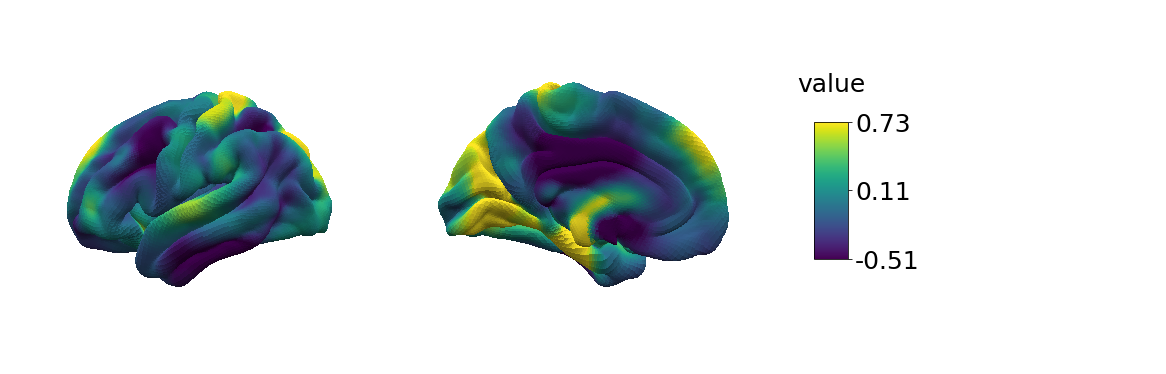

In [33]:
import matplotlib_surface_plotting as msp
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.pial.surf.gii'))

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,grad_mag,rotate=[90,270],
              vmin=np.percentile(grad_mag[cortex],5),vmax=np.percentile(grad_mag[cortex],95))

In [34]:
#comparison with sulcal depth vectors
sulc_vectors=np.load('/data1/allen_surfaces/hcp_surfs_2/template/folding_vectors.npy')


In [35]:
import scripts.nb_loaders as nl
# pc_vectors = nl.load_vectors(os.path.join('pca/principle_components_gradient_vectors_flat.L.func.gii'))
# pc_vectors = np.nan_to_num(pc_vectors[0,:2].T)

# m=np.loadtxt('weighted_island_vectors/mean_z_abs.txt')
# nl.save_array(m*100,'weighted_island_vectors/mean_z_abs.func.gii')
# subprocess.call('wb_command -metric-gradient  -presmooth 3 {} {} {} -vectors {}'.format(
#                        os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.flat.surf.gii'),
#                         'weighted_island_vectors/mean_z_abs.func.gii',
#                         'weighted_island_vectors/mean_z_abs_gradient.func.gii',
#                        'weighted_island_vectors/mean_z_abs_vectors.func.gii'),
#                        shell=True)
# pc_vectors = nl.load_vectors(os.path.join('weighted_island_vectors/mean_z_abs_vectors.func.gii'))
# pc_vectors = pc_vectors[:,:2]
# pc_mag = nl.load_metrics(os.path.join('weighted_island_vectors/mean_z_abs_gradient.func.gii'))

In [36]:
pc_vectors=np.load('pc_vectors.npy',)        

In [37]:
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.very_inflated.surf.gii'))

subsample = subsample_surface(surf.darrays[1].data,cortex,level=3)

In [38]:
import scripts.paths as p

In [39]:
from vast import io_mesh
smooth_mid = io_mesh.load_mesh_geometry(os.path.join(base_dir,'hcp_surfs_2','template','lh.white_smooth.surf.gii'))
inflated = io_mesh.load_mesh_geometry('/data1/allen_surfaces/hcp_surfs_2/template/lh.inflated')
partially_inflated = (1*inflated['coords']+3*smooth_mid['coords'])/4

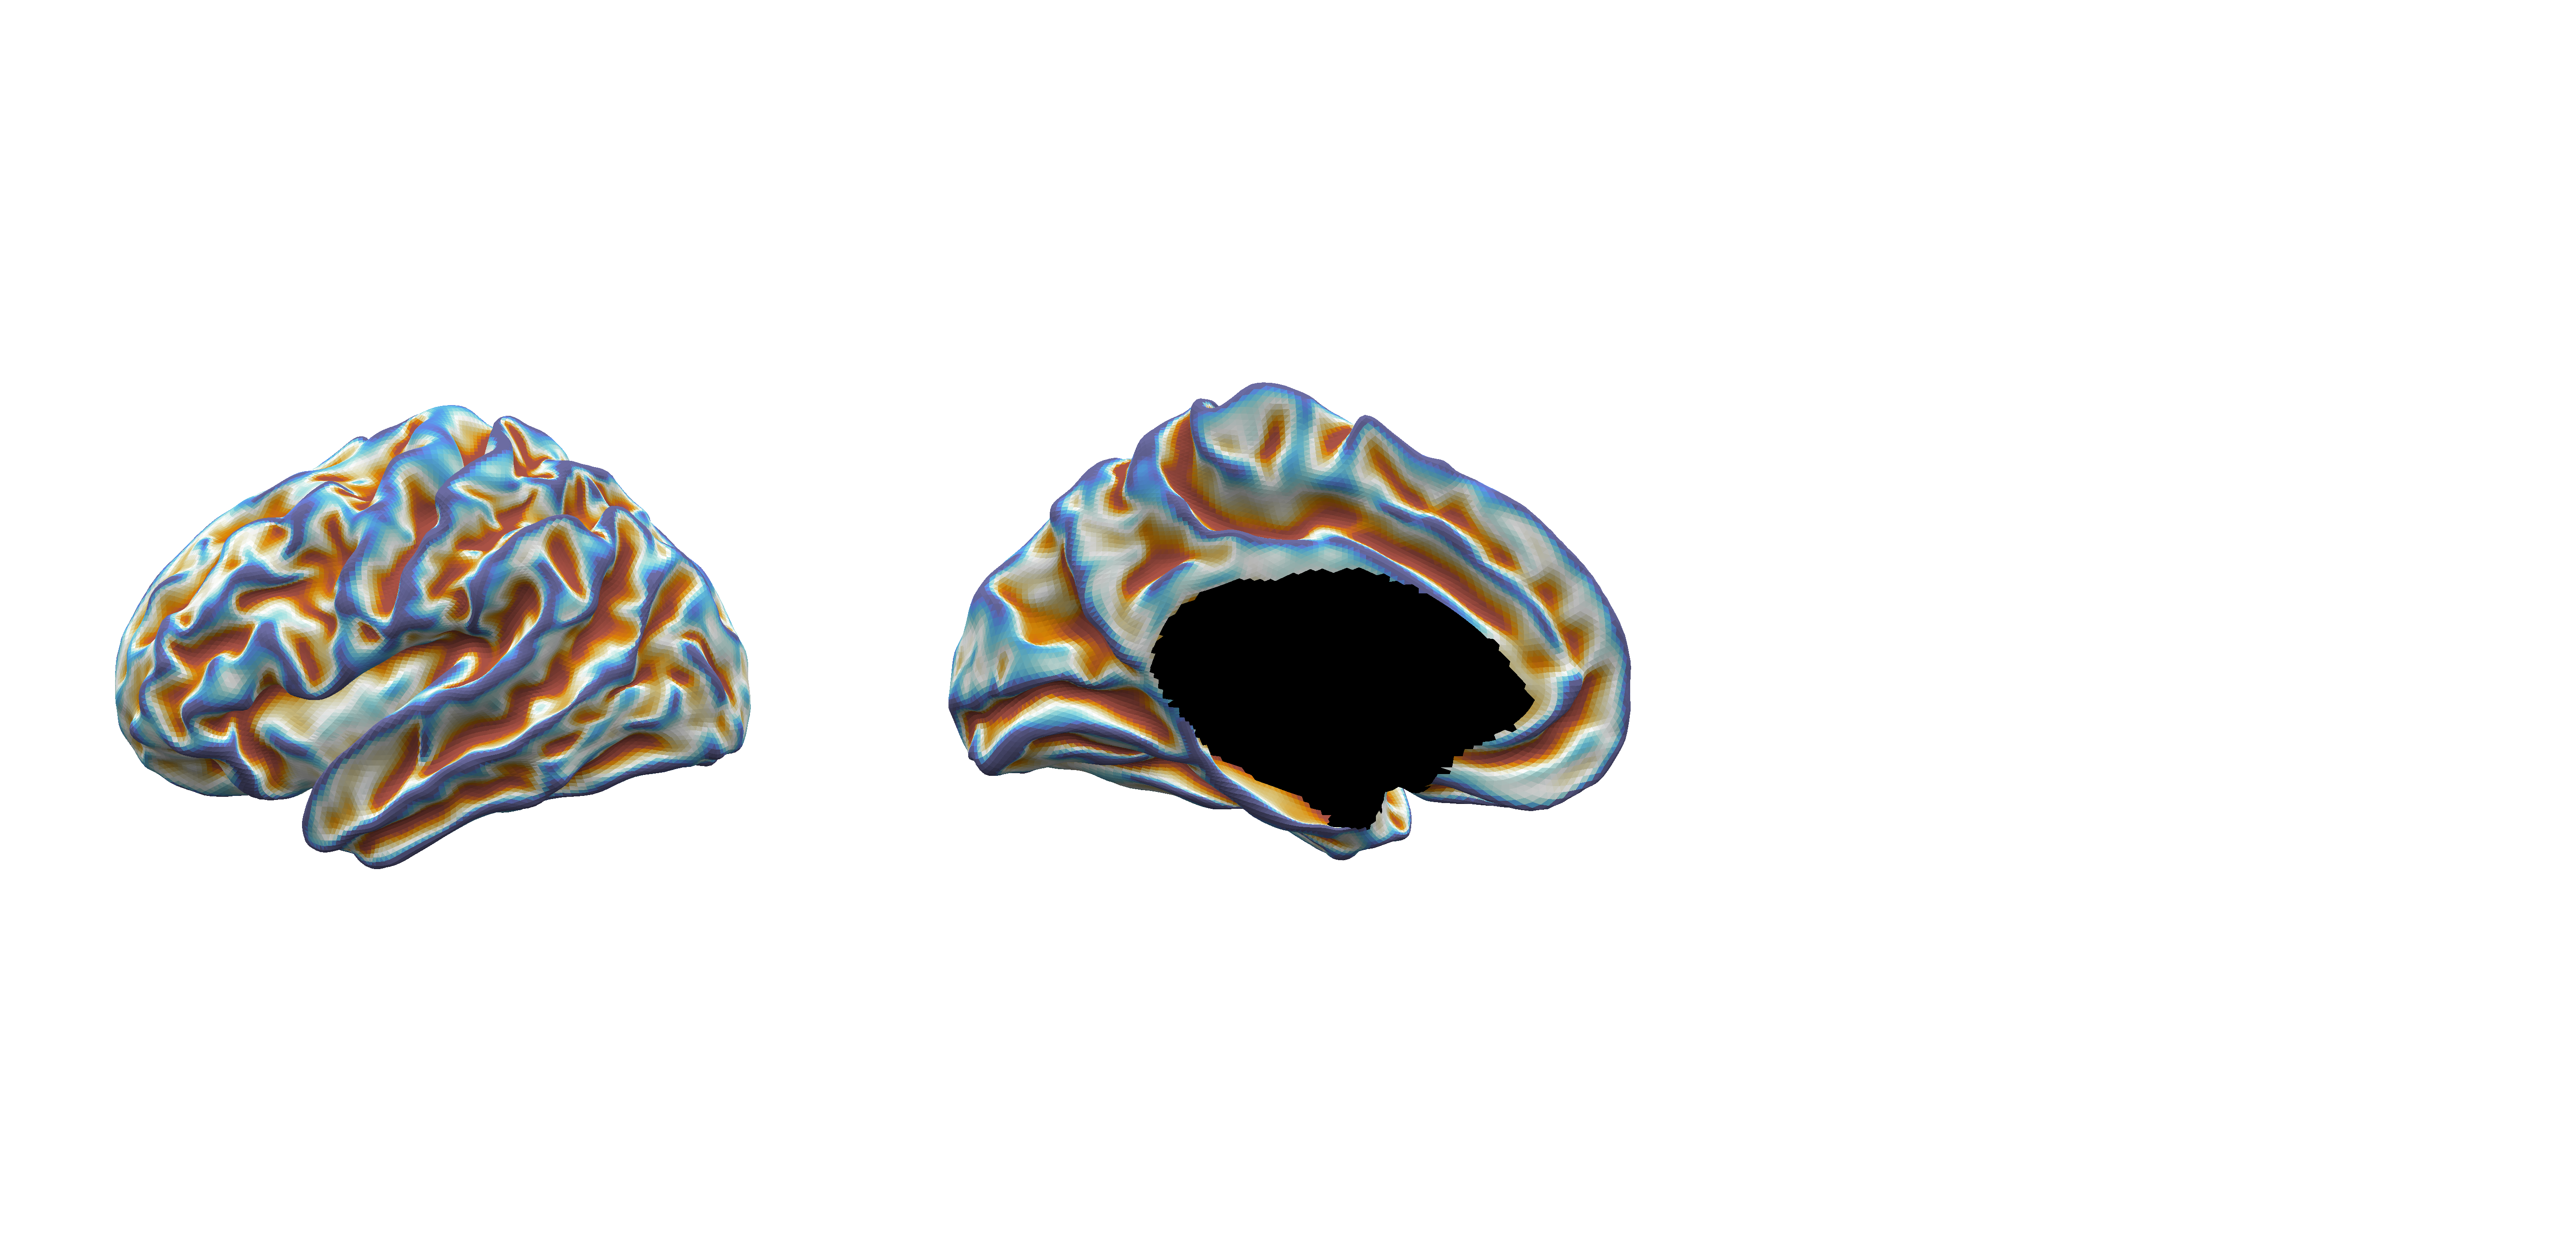

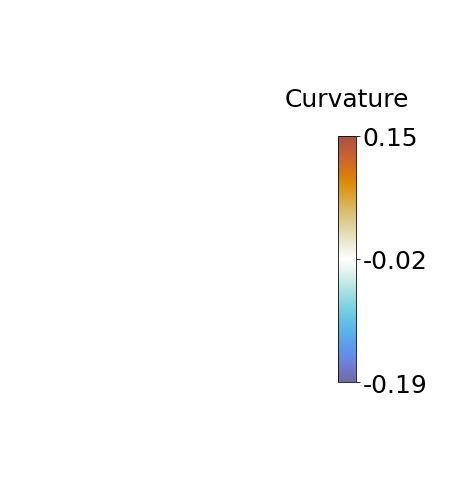

In [40]:
sulc=nb.freesurfer.io.read_morph_data(os.path.join(base_dir,'hcp_surfs_2','template','lh.sm_white.H'))
msp.plot_surf(partially_inflated,inflated['faces'],sulc,
              cmap=p.cmap_hex,vmin=np.percentile(sulc,10),vmax=np.percentile(sulc,90),
              mask=~cortex,
                 mask_colour=np.array([0,0,0,1]),
                  colorbar=False,
              base_size=40,
              filename='folding/folded_curvature.png'
             )
msp.plot_surf(partially_inflated,inflated['faces'],sulc,rotate=[],
              cmap=p.cmap_hex,vmin=np.percentile(sulc,10),vmax=np.percentile(sulc,90),
                 
                  colorbar=True,cmap_label='Curvature',
              base_size=10,
              filename='folding/folded_curvature_cbar.pdf'
             )

/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:9: RuntimeWarning: invalid value encountered in true_divide
  arr[:,0] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:10: RuntimeWarning: invalid value encountered in true_divide
  arr[:,1] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:11: RuntimeWarning: invalid value encountered in true_divide
  arr[:,2] /= lens


0

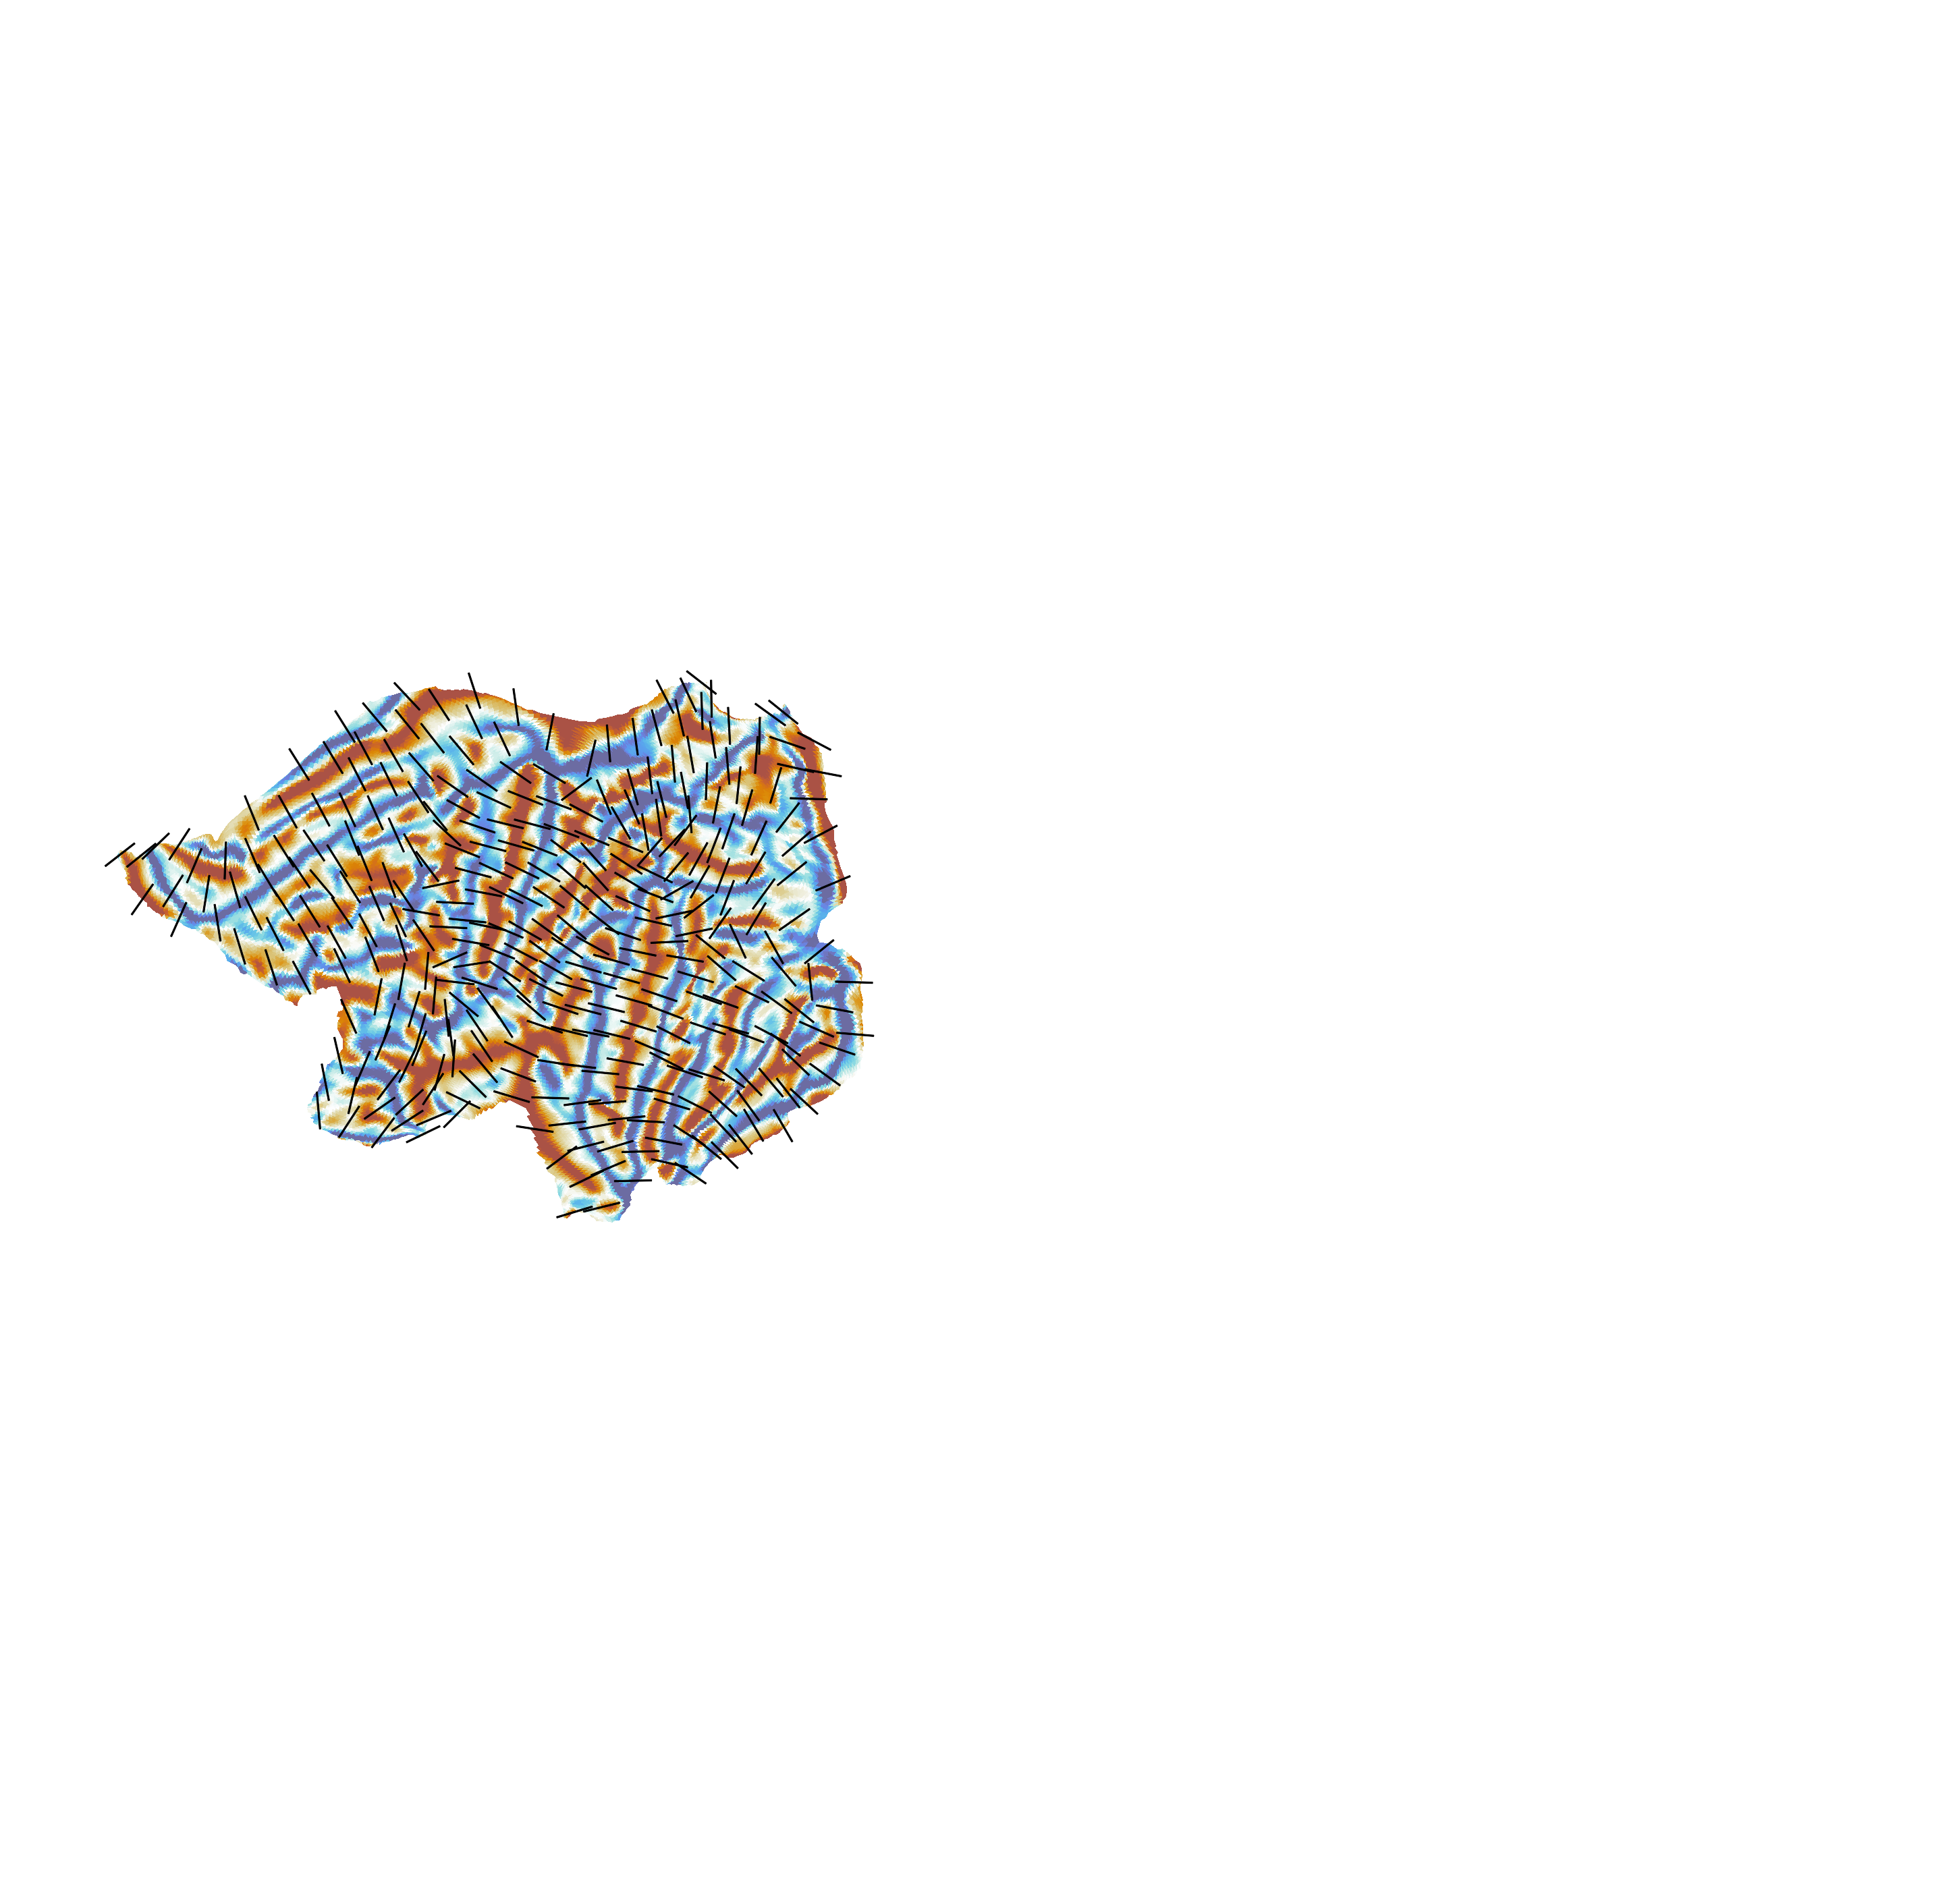

In [41]:
sulc=nb.freesurfer.io.read_morph_data(os.path.join(base_dir,'hcp_surfs_2','template','lh.sm_white.H'))

surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.pial.surf.gii'))
sulc_vectors3=np.zeros((len(sulc_vectors),3))
sulc_vectors3[:,:2]=sulc_vectors
flat=surface_tools.io_mesh.load_mesh_geometry(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                                'fs_LR.32k.L.flat.surf.gii'))
msp.plot_surf(flat['coords'],flat['faces'],sulc,
              cmap=p.cmap_hex,vmin=np.percentile(sulc,10),vmax=np.percentile(sulc,90),
                 flat_map=True,label=True,
                 arrows=sulc_vectors3[subsample],
                 arrow_subset=subsample,arrow_size=0.05,
              arrow_head=0,arrow_width=0.003,
                 # arrow_colours=np.array([['red']*len(subsample)]),
                  colorbar=False,
              base_size=40,
              filename='tmp.png'
             )
subprocess.call('convert tmp.png -trim folding/sulc_arrows.png',shell=True)

In [42]:
import scripts.paths as p
tg_islands=np.loadtxt(os.path.join(p.phate_dir,'gradients','gradient_islands.txt'))
tg_islands = tg_islands>0
subsample = subsample_surface(surf.darrays[1].data,tg_islands,level=3)

In [43]:

combined_arrows = np.zeros((len(subsample)*2,3))
combined_arrows[:,:2]=np.vstack([sulc_vectors[subsample],pc_vectors[subsample]])
combined_arrows=combined_arrows/np.linalg.norm(combined_arrows,axis=1).reshape(-1,1)
combined_indices = np.hstack([subsample,subsample])
combined_colours = np.hstack([['black']*len(subsample),['red']*len(subsample),])

In [44]:
import matplotlib
cmap_tg = matplotlib.colors.LinearSegmentedColormap.from_list('grpr',
                                                              colors=['#E8E4D6','#946B45',])


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


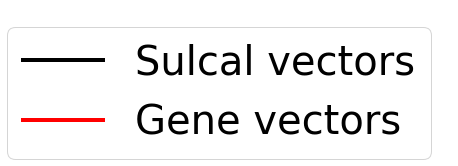

In [45]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='red', lw=4)]
fig, ax = plt.subplots(figsize=(2,1))
#lines = ax.plot(data)
ax.axis('off')
ax.legend(custom_lines, ['Sulcal vectors','Gene vectors', ]);
plt.tight_layout()
fig.savefig('figures/vectors.pdf')

/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:9: RuntimeWarning: invalid value encountered in true_divide
  arr[:,0] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:10: RuntimeWarning: invalid value encountered in true_divide
  arr[:,1] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:11: RuntimeWarning: invalid value encountered in true_divide
  arr[:,2] /= lens


0

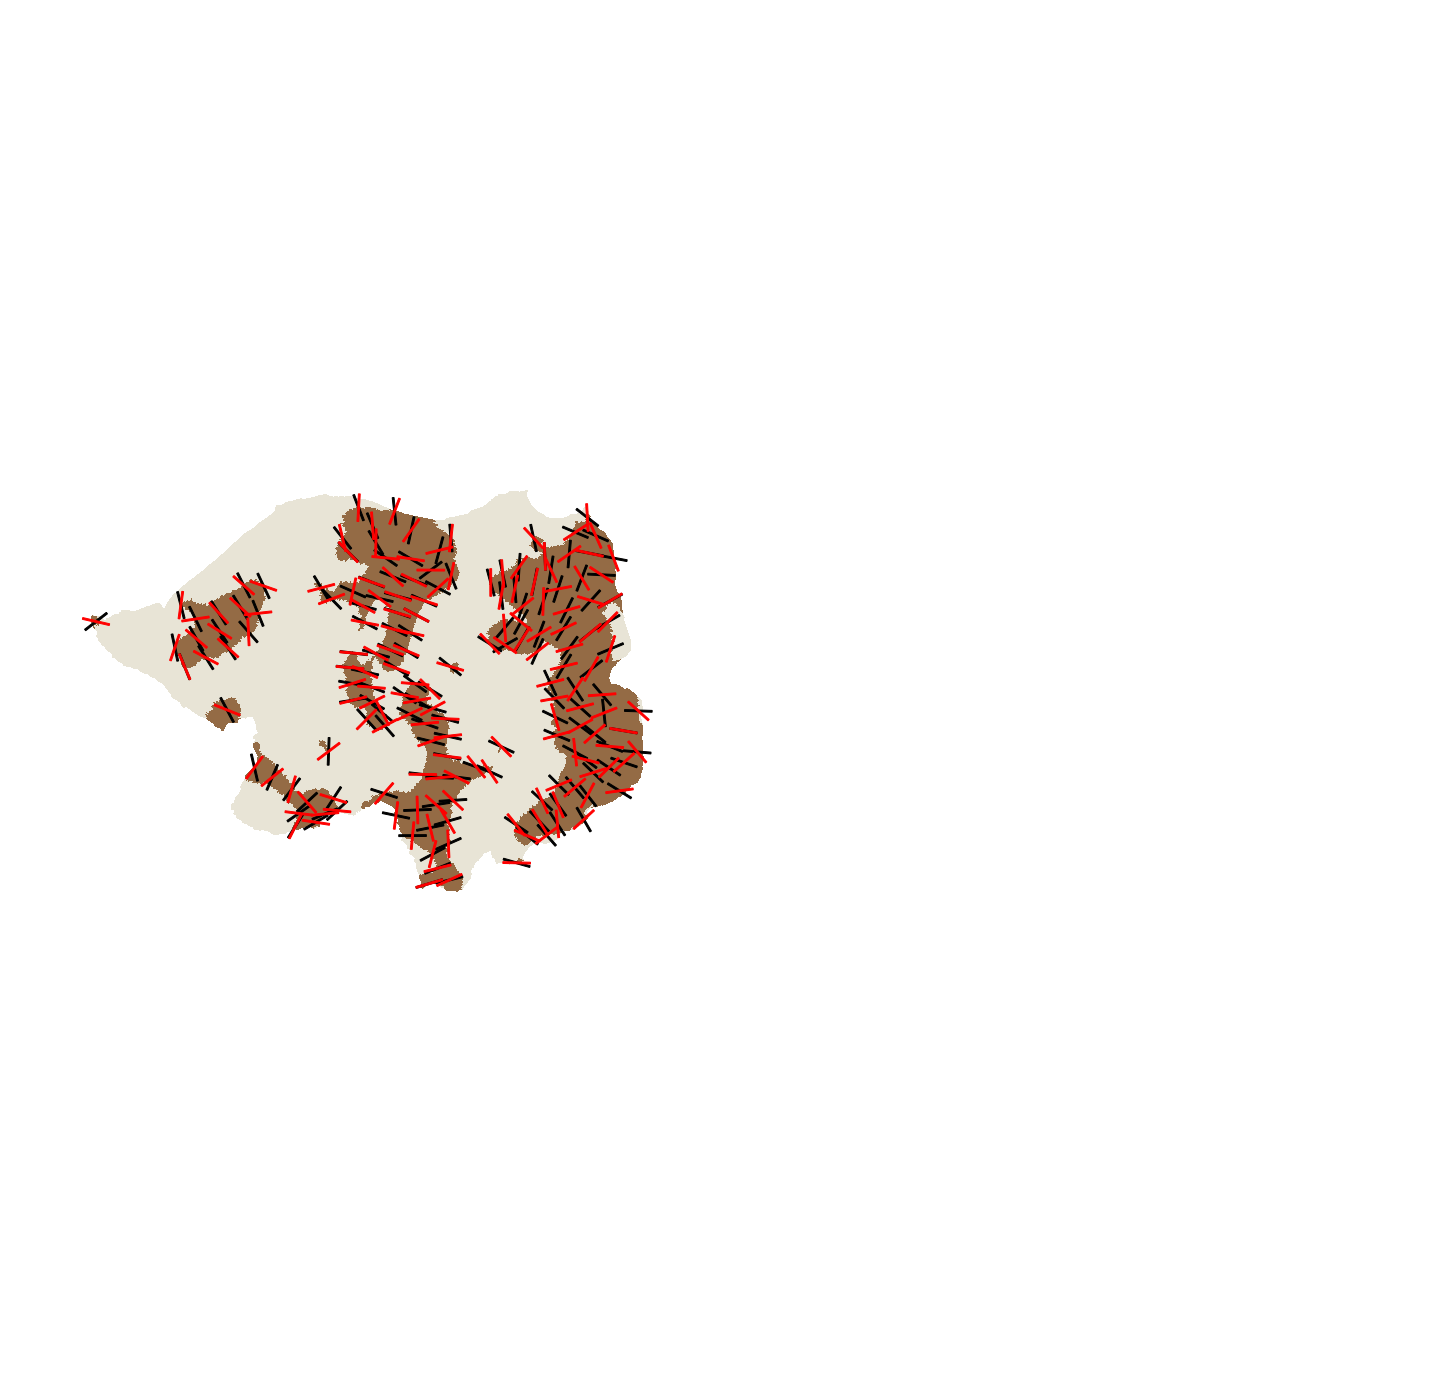

In [46]:
flat=surface_tools.io_mesh.load_mesh_geometry(os.path.join(base_dir,'hcp_surfs','fs_LR32k',
                                'fs_LR.32k.L.flat.surf.gii'))
msp.plot_surf(flat['coords'],flat['faces'],tg_islands,
              cmap=cmap_tg,vmin=0,vmax=1,
                 flat_map=True,label=True,
                 arrows=combined_arrows,
                 arrow_subset=combined_indices,arrow_size=0.05,
              arrow_head=0,arrow_width=0.005,
                  arrow_colours=combined_colours,
                  colorbar=False,
              base_size=20,
             filename='tmp.png'
             )
subprocess.call('convert tmp.png -trim figures/pc_sulc_arrows.png',shell=True)

In [47]:
mean_grad = np.loadtxt('gradients/mean_z.txt')
threshold = np.loadtxt('gradients/spin_threshold.txt')
mask=mean_grad>threshold
mask_c=mask[cortex]

In [ ]:
# pc_vectors_ = nbl.load_vectors('/data1/bigbrain/phate_testing/pca/principle_components_gradient_vectors_flat.L.func.gii')
# pc_vectors_1 = pc_vectors_[1,:2].T


In [ ]:
#nbl.minimum_angles(nbl.angle_between(spun_pc[islands_c][6254].reshape(-1,1),sulc_vectors[tg_islands][6254].reshape(-1,1)))

In [ ]:
#spun_pc[islands_c][6254].reshape(-1,1),sulc_vectors[tg_islands][6254].reshape(-1,1)

In [ ]:
#stats test
angles_between=nbl.minimum_angles(nbl.angle_between(pc_vectors[cortex],sulc_vectors[cortex]))
ks_stat = st.kstest(angles_between/(np.pi/2),'uniform')[0]
skew= st.skew(angles_between/(np.pi/2))
n_perm=1000
spun_angles = np.zeros((n_perm,len(angles_between)))
spun_stats = np.zeros(n_perm)
pc_c=pc_vectors[cortex]
spins = np.load(f'spin_dir/spins_{n_perm}.npy')

#islands_c = tg_islands[cortex]
for p in np.arange(n_perm):
    spun_pc = pc_c[spins[p]]
    spun_angles= nbl.minimum_angles(nbl.angle_between(spun_pc,sulc_vectors[cortex]))
    #spun_angles = spun_angles[~np.isnan(spun_angles)]
    spun_stats[p] = st.skew(spun_angles/(np.pi/2))

In [ ]:
np.mean(skew<spun_stats)

In [ ]:
tree, coords_cortex,cortex,cortex_label = get_tree_and_cortical_coords()

In [ ]:
# circles_angles = np.zeros(len(cortex))
# circles_pval = np.zeros(len(cortex))
# ratio_var_exp = np.zeros(len(cortex))
# import time
# for k,v_i in enumerate(cortex_label):
# #     if k %1000==0:
# #         print(k)
    
#     vertex_0=tree.query(coords_cortex[k],k=200)[1]
#     vertex_mask=np.zeros(np.sum(cortex>0)).astype(bool)
#     vertex_mask[vertex_0]=1
#     t1=time.time()
#     #THIS MEAN ANGLE IS NOT CORRECT
#     counts,bins=np.histogram(angles_between[vertex_mask],bins=np.linspace(0,np.pi/2,19))

#     circles_angles[v_i] = np.mean([bins[np.argmax(counts)],bins[np.argmax(counts)+1]])
#     ratio_var_exp[v_i] = np.mean(gene_pc_ratio[cortex][vertex_mask])
#     #t2=time.time()
# #     ks_stat = st.skew(angles_between[vertex_mask])
#     spun_stats = st.skew(spun_angles[:,vertex_mask], axis=0)
#     #t3=time.time()
#     circles_pval[v_i] = np.mean(ks_stat>spun_stats)
#     #print(t3-t2,t2-t1)

In [ ]:
# ratio_var_exp= np.nan_to_num(ratio_var_exp)

In [ ]:
# circles_angles = np.rad2deg(circles_angles)

In [ ]:
import matplotlib
fig, ax = plt.subplots(1,1,figsize=(5,5))
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)
skew= st.skew(angles_between/(np.pi/2))
sns.distplot(np.rad2deg(angles_between),kde=False,hist=True, bins=9,
             #kde_kws={'clip': (0.0, 90.0),'bw':0.2,'cut':0},
             )
ax.set_ylabel('n vertices')
ax.set_xlabel('Folds vs\ngene gradient (°)')
ax.set_xticks(np.linspace(0,90,2));
ax.set_yticks([]);

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(45,4500,  'Skew = {}'.format(np.round(skew,2))+
          
                                        '\np$_{spin}$<0.01',
          fontsize=23,
        verticalalignment='top', bbox=props)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('figures/folding_group_skew.pdf')

In [ ]:
import matplotlib
import scripts.paths as p

#cmap_hex=p.cmap_hex
full = np.zeros(len(cortex))
full[cortex] = np.rad2deg(angles_between)

surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.inflated.surf.gii'))
surf_p = nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.pial.surf.gii'))
partial = (surf.darrays[0].data+surf_p.darrays[0].data)/2

msp.plot_surf(partial,surf.darrays[1].data,full,rotate=[90,270],
              vmin=0,vmax=90,base_size=10,
              mask = ~cortex,#pvals = np.ones_like(tg_islands),
              mask_colour=np.array([0,0,0,1]),
              cmap_label='Angle (°)',
             cmap=p.cmap_hex,colorbar=False,
             filename='folding/angles_between.png')

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,full,rotate=[],
              vmin=0,vmax=90,base_size=10,
              mask = ~cortex,#pvals = np.ones_like(tg_islands),
              cmap_label='Angle (°)',
             cmap=p.cmap_hex,
             filename='folding/angles_between_cbar.pdf')

In [ ]:
plt.hist(np.rad2deg(angles_between))

In [ ]:
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,mask,rotate=[90,270],
              #vmin=np.percentile(circles_angles[cortex],1),vmax=np.percentile(circles_angles[cortex],99),
             cmap='viridis')

In [ ]:
st.spearmanr(circles_angles[cortex],ratio_var_exp[cortex])

In [ ]:
surf=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','fs_LR.32k.L.inflated.surf.gii'))

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,ratio_var_exp,rotate=[90,270],
              vmin=np.percentile(ratio_var_exp[cortex],1),vmax=np.percentile(ratio_var_exp[cortex],99),
             cmap='turbo',
             title='var_exp ')

In [ ]:

sns.kdeplot(circles_angles[cortex],min_distances[cortex])
plt.ylabel('distance from nearest island')
plt.xlabel('Gradient magnitude')
#plt.text(70,1.5,f'rho= {np.round(corr,2)}\np_spin={np.mean(corr>spun_corr)}')

In [ ]:
st.spearmanr(circles_angles[cortex],min_distances[cortex])

In [ ]:
sns.distplot(spun_stats)
ks_stat

In [ ]:
sns.distplot(angles_between)

In [ ]:
subset = np.random.choice(vertices,5000)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
# from nilearn import plotting, datasets
# plotting.view_surf(os.path.join(base_dir,'hcp_surfs', subject,'MNINonLinear','fsaverage_LR32k',
#                                 '{}.L.inflated.32k_fs_LR.surf.gii'.format(subject)),      
#                            cmap='viridis', symmetric_cmap=False )
ax = fig.gca()
ax.scatter(flat['coords'][:,0], flat['coords'][:,1],c=grad_mag,vmax=0.4,s=7)
ax.scatter(flat['coords'][:,0][borders],flat['coords'][:,1][borders],color='red',s=2)
ax.axis('equal')
ax.axis('off')

ax.quiver(flat['coords'][subset,0], flat['coords'][subset,1],
          50*sulc_vectors[subset,0],50*sulc_vectors[subset,1],scale=1800,headwidth=0.1)


/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Angle between folding vectors\nand principal gene gradient')

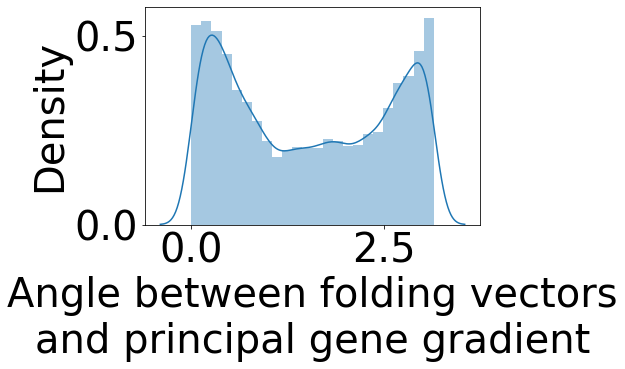

In [48]:
import seaborn as sns
import scipy.stats as st
angles_between=nbl.angle_between(pc_vectors[cortex],sulc_vectors[cortex])
sns.distplot(angles_between)
#plt.xlim([0,180])
plt.xlabel('Angle between folding vectors\nand principal gene gradient')

In [7]:
#Rank PC for each vertex inside TG islands. Compare to island lists and delta lists
#Can they be described by the deltas/islands/PCS?
import vast.surface_tools as surf_t

tg_islands=np.loadtxt(os.path.join('gradients','gradient_islands.txt'))

tg_islands2=surf_t.compute_islands(tg_islands>0,neighbours)

tg_islands2[tg_islands==0]=0
tg_islands2[tg_islands2>5]=0
tg_islands2[cortex]=0

vertices=np.where(tg_islands>0)[0]
pca=sklearn.decomposition.PCA(n_components=1)
pc_lists = np.zeros((len(cortex),n_genes)).astype(int)
pc_vectors = np.zeros((len(cortex),2))
mask=[]
for k,v in enumerate(vertices):
    vertex_vecs = flat_vectors[:,:2,v]
    if not np.all(vertex_vecs==0):
        pc_lists[v] = rank_vector(pca.fit_transform(vertex_vecs).ravel())
        pc_vectors[v]= pca.components_[0]
    else:
        mask.append(k)


In [8]:
#load genexp, meanz and islands
#find peaks in islands
#get gene exp vectors for peak vertices
##calculate pairwise deltas for peaks
base_dir = '/data1/allen_surfaces/'
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0
gene_names=np.loadtxt('weighted_island_vectors/gene_names.txt',dtype=str)
concat= np.load('/data1/allen_surfaces/all_subs_smoothed_z.npy')
surf=nb.load(os.path.join(base_dir,'hcp_surfs', 'fs_LR32k',
                                'fs_LR.32k.L.inflated.surf.gii'))
td_islands = np.loadtxt('weighted_island_vectors/clustered_islands.txt').astype(int)
peaks = np.zeros(len(cortex))
islands_exp=np.zeros((6,concat.shape[0]))
mean_z = np.loadtxt('weighted_island_vectors/mean_z_abs.txt')
with open('weighted_island_vectors/glasser_rois.json') as f:
    d=json.load(f)
td_rois=[d['{}'.format(x)][0][2:-4] for x in np.arange(6)+1]

for island in np.unique(td_islands)[1:]:
    island_verts = np.where(td_islands==island)[0]
    peak=island_verts[np.argmax(mean_z[td_islands==island])]
    peaks[peak]=1
    islands_exp[island]=concat[:,peak]
    
    
# deltas = [] #np.zeros((6,6,concat.shape[0]))
# delta_names=[]
# for k in np.unique(td_islands)[1:]:
#     for x in np.unique(td_islands)[1:]:
#         if k==x:
#             pass
#         elif x>k:
#             deltas.append((islands_exp[k]-islands_exp[x]).argsort().argsort())
#             delta_names.append(f'{td_rois[x]} - {td_rois[k]}')
            
# deltas_and_islands = np.vstack([deltas,islands_exp.argsort().argsort()])
# deltas_and_islands_names = np.hstack([delta_names,td_rois])
# deltas_and_islands_names

In [83]:
#deltas_and_islands= deltas_and_islands.astype(np.float32)
pc_lists = pc_lists.astype(np.float32)

In [84]:
def corr2_coeff_accel(A_mA,ssA,B) :
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    #A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    #ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);
    # Finally get corr coeff
    #This is the slowest step
    dot=np.dot(A_mA,B_mB.T)
    dot2=np.dot(ssA[:,None],ssB[None])
    
    sqrt=np.sqrt(dot2)
    var=dot/sqrt
   
    return var

In [85]:
vertices=np.where(tg_islands>0)[0]

pc_lists=pc_lists[vertices]

In [86]:
def corr2_coeff_accel(A_mA,ssA,B) :
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    #A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    #ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);
    # Finally get corr coeff
    #This is the slowest step
    dot=np.dot(A_mA,B_mB.T)
    dot2=np.dot(ssA[:,None],ssB[None])
    
    sqrt=np.sqrt(dot2)
    var=dot/sqrt
   
    return var

A = pc_lists
A_mA = A - A.mean(1)[:,None]
A_mA = A_mA.copy(order='C')
ssA = (A_mA**2).sum(1)
correlations=corr2_coeff_accel(A_mA,ssA, rank_matrix( islands_exp))

In [87]:
pc_vectors_3 = np.zeros((len(cortex),3))
pc_vectors_3[:,:2]=pc_vectors

In [88]:
from PIL import Image

In [89]:
mask = tg_islands>0

In [90]:
cmap = plt.get_cmap("tab20")
colorsd = cmap(np.arange(20))
colorsd=colorsd[np.round(np.linspace(0,19,7)).astype(int)]

In [91]:
# plot each of the island maps
fig,axes = plt.subplots(2,3,figsize=(25,14))
colors = {0:np.array([1,0,0,1]),
         1:np.array([1,0,0,1]),
         2:np.array([1,0,0,1])}
td_order = [ 'V1', '2', '4', 'TGd', 'OFC', '9-46d']
subsample = subsample_surface(surf.darrays[1].data,cortex,level=2)
axes = axes.ravel()
for k in np.arange(6):
#    c = np.abs(correlations[:,k])
    #island specific colors
    
    
    i = td_rois.index(td_order[k])
    colors = {0:colorsd[i+1],
         1:colorsd[i+1],
         2:colorsd[i+1]}
    c = np.abs(correlations[:,i])

    parcellation = (td_islands==i).astype(int)
    full = np.zeros(len(cortex))

    full[vertices] = np.nan_to_num(c)
    thresh=np.percentile(full,99)
    #subset = np.random.choice(np.where(full>thresh)[0],20)
    subset = np.intersect1d(subsample,np.where(full>thresh)[0])
    arrow_colours=np.ones_like(pc_vectors_3)
    arrow_colours[:,1:3]=0
    msp.plot_surf(flat['coords'],flat['faces'],full,
                      base_size=20,vmin=0,vmax=0.6,
                  mask =~mask,pvals = np.ones_like(mask),
                      cmap='viridis',
                     flat_map=True,
                     arrows=pc_vectors_3,
                     arrow_subset=subset,arrow_size=0.05,
                      arrow_colours=arrow_colours,arrow_head=0,arrow_width=0.007,
                      colorbar=False,cmap_label='TD corr',parcel=parcellation+1,parcel_cmap=colors,
                  filename='tmp.png'
                     )
    plt.close('all')
    subprocess.call('convert tmp.png -trim gradients/tmp.png',shell=True)
    im  = Image.open('gradients/tmp.png')
    im = np.array(im)
    axes[k].imshow(im)
    name = td_rois[i]
    if name=='2':
        name='BA2'
    elif name == '4':
        name='BA4'
    axes[k].set_title(name,fontdict={'fontsize':40})

#    axes[k//3,k%3].axis('equal')
    axes[k].axis('off')
plt.tight_layout()
fig.savefig('figures/islands_gradients_vectors.pdf')

/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:9: RuntimeWarning: invalid value encountered in true_divide
  arr[:,0] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:10: RuntimeWarning: invalid value encountered in true_divide
  arr[:,1] /= lens
/data1/testing_plotters/matplotlib_surface_plotting/matplotlib_surface_plotting/matplotlib_surface_plotting.py:11: RuntimeWarning: invalid value encountered in true_divide
  arr[:,2] /= lens


<Figure size 432x288 with 0 Axes>

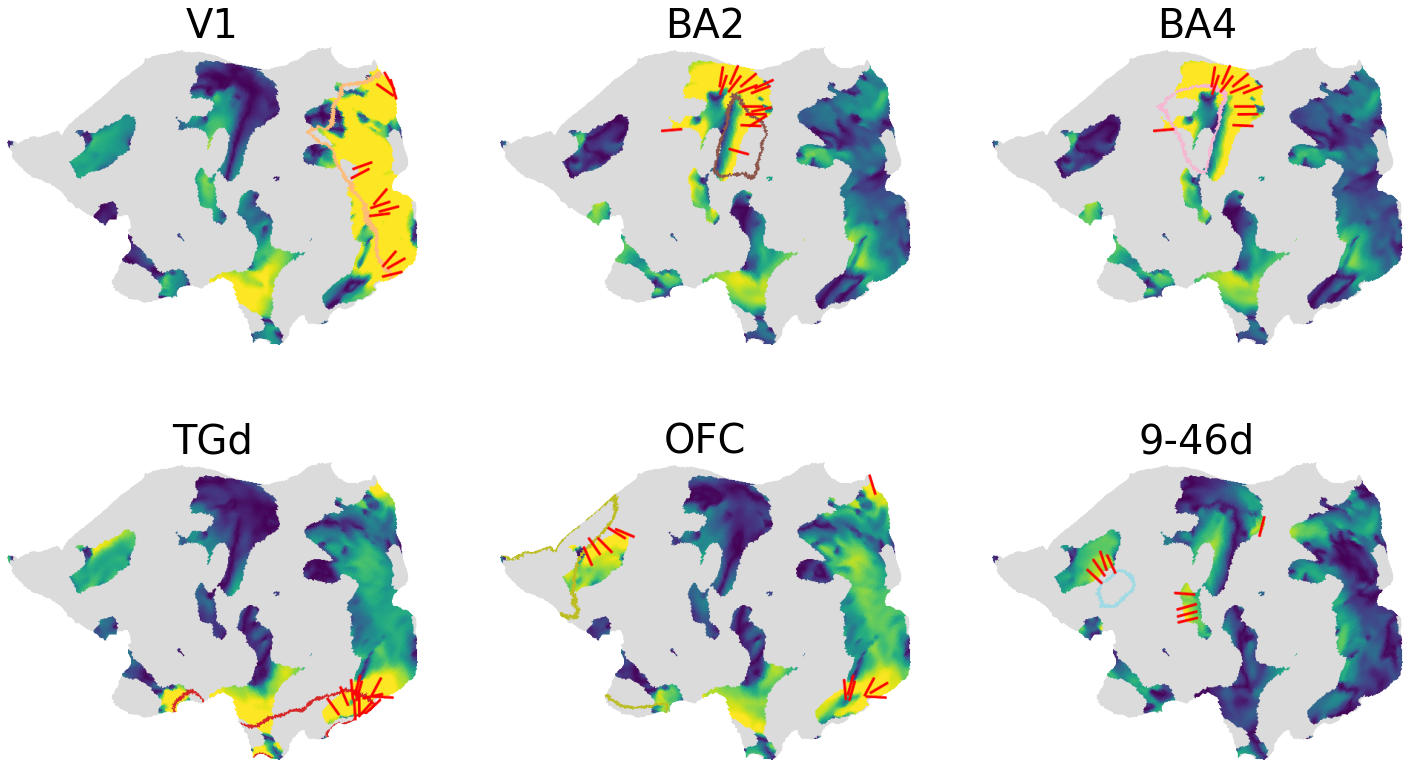

In [92]:
fig

In [65]:
#fig = plt.figure(figsize=(10,10))
# fig,axes = plt.subplots(2,3,figsize=(12,7))

# for k in np.arange(6):
#     c = np.abs(correlations[:,k])
#     region = np.where(td_islands==k)[0]
#     flat_list = [item for sublist in list(neighbours[region]) for item in sublist]
#     border= np.setdiff1d(np.array(flat_list),region)
#     full = np.zeros(len(cortex))

#     full[vertices] = np.nan_to_num(c)
#     thresh=np.percentile(full,99)
#     subset = np.random.choice(np.where(full>thresh)[0],20)
    
#     axes[k//3,k%3].scatter(flat['coords'][:,0], flat['coords'][:,1],c=full,vmin=0,
#                vmax=thresh,s=7,cmap='viridis')
#     axes[k//3,k%3].scatter(flat['coords'][:,0][border],flat['coords'][:,1][border],color='red',s=2)

#     axes[k//3,k%3].axis('equal')
#     axes[k//3,k%3].axis('off')
    
#     axes[k//3,k%3].quiver(flat['coords'][subset,0]-40*pc_vectors[subset,0]*0.5,
#                           flat['coords'][subset,1]-40*pc_vectors[subset,1]*0.5,
#           200*pc_vectors[subset,0],200*pc_vectors[subset,1],scale=1800,headwidth=0.1,color='w')
#     axes[k//3,k%3].set_title(td_rois[k])
    

In [ ]:
full = np.zeros(len(cortex))

for k in np.arange(6):
    c = np.abs(correlations[:,-(k+1)])
    full[vertices] = np.nan_to_num(c)
    msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,full,rotate=[90,270],cmap='turbo',vmin=0,vmax=1,
             label=True,title=deltas_and_islands_names[-(k+1)])

plotting


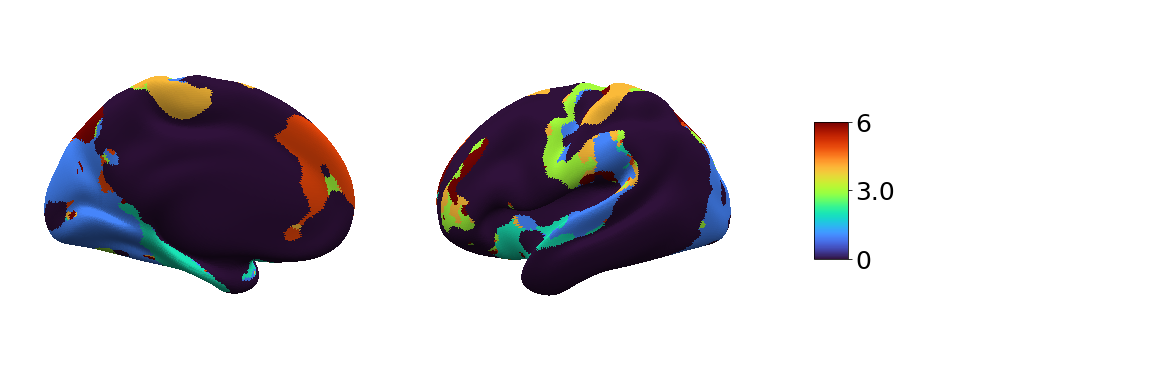

In [47]:
full = np.zeros(len(cortex))
full[vertices] = np.nan_to_num(np.argmax(np.abs(correlations[:,-6:]),axis=1))+1
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,full,rotate=[270,90],cmap='turbo',vmin=0,vmax=6,
             label=True)